In [1]:
!pip install rouge-score
!pip install torchmetrics

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=fb2600b52b0153d976fce6048c8625a63ae5d8597b781667e8aaf06bf947a86e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 12.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import pandas as pd
from transformers import GPT2Tokenizer
import os
import torch
import torch.nn as nn
import math
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torchmetrics.text.bleu import BLEUScore
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [ ]:
path = '/content/drive/MyDrive/RESEARCH/DNN/HW3/Shakespeare_data.csv'

df = pd.read_csv(path)
df

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
...,...,...,...,...,...,...
111391,111392,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely"
111392,111393,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part
111393,111394,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first
111394,111395,A Winters Tale,38.0,5.3.183,LEONTES,We were dissever'd: hastily lead away.


In [ ]:
df = df.dropna(subset=["Play", "Player", "PlayerLine"])

def build_tagged_corpus(df):
    corpus = []
    for _, row in df.iterrows():
        play = row["Play"]
        speaker = row["Player"]
        text_line = row["PlayerLine"]  # the actual spoken line

        # Construct your tagged string:
        tagged_line = f"<PLAY={play}> <SPEAKER={speaker}> {text_line}"
        corpus.append(tagged_line)
    return corpus

corpus = build_tagged_corpus(df)
print(len(corpus))
corpus

111389


['<PLAY=Henry IV> <SPEAKER=KING HENRY IV> So shaken as we are, so wan with care,',
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> Find we a time for frighted peace to pant,',
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> And breathe short-winded accents of new broils',
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> To be commenced in strands afar remote.',
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> No more the thirsty entrance of this soil',
 "<PLAY=Henry IV> <SPEAKER=KING HENRY IV> Shall daub her lips with her own children's blood,",
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> Nor more shall trenching war channel her fields,',
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> Nor bruise her flowerets with the armed hoofs',
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> Of hostile paces: those opposed eyes,',
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> Which, like the meteors of a troubled heaven,',
 '<PLAY=Henry IV> <SPEAKER=KING HENRY IV> All of one nature, of one substance bred,',
 '<PLAY=Henry IV> <SPEAKER=KING H

# Character level tokenizer

In [ ]:
class CharacterTokenizer:
    def __init__(self):
        self.vocab = {}
        self.reverse_vocab = {}

    def build_vocab(self, corpus):
        # Build vocabulary of unique characters
        self.vocab['<SOS>'] = 0
        self.vocab['<EOS>'] = 1
        self.vocab['<PAD>'] = 2

        unique_chars = sorted(set("".join(corpus)))
        print(unique_chars)
        for idx, char in enumerate(unique_chars, start=3):
            self.vocab[char] = idx
        self.reverse_vocab = {idx: char for char, idx in self.vocab.items()}

    def tokenize(self, text):
            """
            Convert a single line/string into token IDs,
            prepending <SOS> and appending <EOS>.
            """
            # Map each character to its ID, raising an error if char not in vocab
            token_ids = []
            for ch in text:
                if ch not in self.vocab:
                    # handle unknown chars.
                    # For now, just skip or raise an error.
                    raise ValueError(f"Character {repr(ch)} not in vocab!")
                token_ids.append(self.vocab[ch])

            return [self.vocab['<SOS>']] + token_ids + [self.vocab['<EOS>']]

    def detokenize(self, token_ids):
        """
        Convert token IDs back to a string, ignoring <SOS>, <EOS>, <PAD>.
        """
        special_tokens = {self.vocab['<SOS>'], self.vocab['<EOS>'], self.vocab['<PAD>']}
        chars = []
        for tid in token_ids:
            if tid not in special_tokens:  # skip special tokens
                chars.append(self.reverse_vocab[tid])
        return "".join(chars)

In [ ]:
# 1) Initialize and build vocab
tokenizer = CharacterTokenizer()
tokenizer.build_vocab(corpus)

# 2) Tokenize one line
sample_line = corpus[0]
token_ids = tokenizer.tokenize(sample_line)
print("Token IDs:", token_ids)

# 3) Detokenize
reconstructed = tokenizer.detokenize(token_ids)
print("Detokenized text:", reconstructed)

# 4) Check <PAD>
PAD_ID = tokenizer.vocab['<PAD>']
print("PAD token ID:", PAD_ID)

['\t', ' ', '!', '$', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Token IDs: [0, 24, 43, 39, 28, 52, 25, 35, 60, 69, 73, 80, 4, 36, 49, 26, 4, 24, 46, 43, 32, 28, 38, 32, 45, 25, 38, 36, 41, 34, 4, 35, 32, 41, 45, 52, 4, 36, 49, 26, 4, 46, 70, 4, 74, 63, 56, 66, 60, 69, 4, 56, 74, 4, 78, 60, 4, 56, 73, 60, 10, 4, 74, 70, 4, 78, 56, 69, 4, 78, 64, 75, 63, 4, 58, 56, 73, 60, 10, 1]
Detokenized text: <PLAY=Henry IV> <SPEAKER=KING HENRY IV> So shaken as we are, so wan with care,
PAD token ID: 2


# Subword tokenizer

In [ ]:
# Load GPT-2 tokenizer
subword_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add <SOS> and <EOS>
special_tokens = {"additional_special_tokens": ["<SOS>", "<EOS>"]}
subword_tokenizer.add_special_tokens(special_tokens)

def subword_tokenize(text):
    sos_token = subword_tokenizer.convert_tokens_to_ids("<SOS>")
    eos_token = subword_tokenizer.convert_tokens_to_ids("<EOS>")
    tokens = subword_tokenizer.encode(text, add_special_tokens=False)
    return [sos_token] + tokens + [eos_token]

# Example Usage
tokens = subword_tokenize("To be, or not to be.")
print(tokens)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

[50257, 2514, 307, 11, 393, 407, 284, 307, 13, 50258]


In [ ]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # shape => (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)  # e.g., 128
        # Add positional encoding
        x = x + self.pe[:, :seq_len, :]
        return x

In [ ]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, d_model, num_heads):
        """
        d_model: total embedding dimension
        num_heads: number of attention heads
        """

        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads


        # Create parameter matrices for Q, K, V, and the final output projection.
        # Each is size (d_model, d_model). We could also separate them into
        # (d_model, head_dim) blocks, but it's standard to keep them (d_model, d_model)
        # and reshape/split.

        self.W_Q = nn.Parameter(torch.randn(d_model, d_model))
        self.W_K = nn.Parameter(torch.randn(d_model, d_model))
        self.W_V = nn.Parameter(torch.randn(d_model, d_model))

        self.W_O = nn.Parameter(torch.randn(d_model, d_model))  # final output projection

        self.b_Q = nn.Parameter(torch.zeros(d_model))
        self.b_K = nn.Parameter(torch.zeros(d_model))
        self.b_V = nn.Parameter(torch.zeros(d_model))
        self.b_O = nn.Parameter(torch.zeros(d_model))

  def forward(self, x):
      """
      x: (batch_size, seq_len, d_model)

      Returns: (batch_size, seq_len, d_model)
      """

      # print("MHA input:", x.shape)
      B, T, _ = x.shape

      # 1) Compute Q, K, V via matrix multiplies (no nn.Linear, no einsum).
      #    We'll first reshape (B, T, d_model) -> (B*T, d_model) so we can do 2D matmul easily.

      x_2d = x.reshape(B*T, self.d_model)  # shape: (B*T, d_model)


      # Q = x_2d @ W_Q + b_Q
      Q_2d = torch.matmul(x_2d, self.W_Q) + self.b_Q  # (B*T, d_model)
      K_2d = torch.matmul(x_2d, self.W_K) + self.b_K  # (B*T, d_model)
      V_2d = torch.matmul(x_2d, self.W_V) + self.b_V  # (B*T, d_model)

      # Reshape back to 3D, then split heads:
      # Q, K, V => (B, T, d_model) => (B, T, num_heads, head_dim) => transpose => (B, num_heads, T, head_dim)
      Q = Q_2d.reshape(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)
      K = K_2d.reshape(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)
      V = V_2d.reshape(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)

      # 2) Compute attention scores = Q * K^T / sqrt(head_dim)
      #    Q: (B, n_heads, T, head_dim)
      #    K^T: (B, n_heads, head_dim, T)
      # => attn_scores: (B, n_heads, T, T)

      # We'll do matmul along the last dimension:
      attn_scores = torch.matmul(Q, K.transpose(-2, -1))  # shape: (B, n_heads, T, T)
      attn_scores = attn_scores / (self.head_dim ** 0.5)

      # 3) Apply auto-regressive (causal) masking (lower triangular)
      #    We create a (T, T) mask that is 1.0 in the lower triangle and 0.0 in the upper triangle.
      mask = torch.tril(torch.ones(T, T, device=x.device, dtype=torch.bool))
      # mask: shape (T, T) with True in lower-tri, False in upper-tri

      # Broadcast to (B, n_heads, T, T) if needed:
      # Here, we'll directly use masked_fill where mask == False => -inf:
      # attn_scores: (B, n_heads, T, T)
      attn_scores = attn_scores.masked_fill(~mask, float('-inf'))

      # 4) Convert scores to probabilities
      attn_weights = F.softmax(attn_scores, dim=-1)  # (B, n_heads, T, T)

      # 5) Weighted sum over V => attn_output
      #    attn_weights: (B, n_heads, T, T)
      #    V: (B, n_heads, T, head_dim)
      # => attn_output: (B, n_heads, T, head_dim)
      attn_output = torch.matmul(attn_weights, V)  # (B, n_heads, T, head_dim)

      # 6) Reshape back to (B, T, d_model)
      #    Currently: (B, n_heads, T, head_dim) => transpose => (B, T, n_heads, head_dim) => flatten
      attn_output = attn_output.transpose(1, 2).reshape(B, T, self.d_model)  # (B, T, d_model)

      # 7) Final output projection (again using matmul)
      #    shape => (B, T, d_model)
      attn_out_2d = attn_output.reshape(B*T, self.d_model)         # (B*T, d_model)
      out = torch.matmul(attn_out_2d, self.W_O) + self.b_O         # (B*T, d_model)
      out = out.reshape(B, T, self.d_model)                        # back to (B, T, d_model)

      return out



In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        """
        d_model: The input/output dimension of the Transformer (embedding size)
        d_ff: The hidden (intermediate) dimension
        """
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU()  # or GELU, etc.

    def forward(self, x):
        """
        x: shape (batch_size, seq_len, d_model)
        """
        # 1) First linear layer + activation
        x = self.fc1(x)            # => (batch_size, seq_len, d_ff)
        x = self.activation(x)     # => (batch_size, seq_len, d_ff)

        # 2) Second linear layer
        x = self.fc2(x)            # => (batch_size, seq_len, d_model)
        return x

In [ ]:
class CustomLayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        """
        dim: the dimension over which we want to apply LN (e.g., d_model)
        eps: a small number to prevent divide-by-zero
        """
        super().__init__()
        self.eps = eps
        # Learnable parameters, shape: (dim,)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta  = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        """
        x: shape (B, T, dim) or (B, dim) or similar,
           we typically normalize over the last dimension.
        """
        # 1) Compute mean over the last dimension
        mean = x.mean(dim=-1, keepdim=True)  # shape: (B, T, 1)

        # 2) Compute variance over the last dimension
        #    'unbiased=False' for consistency with PyTorch’s nn.LayerNorm
        var = x.var(dim=-1, keepdim=True, unbiased=False)  # shape: (B, T, 1)

        # 3) Normalize
        x_norm = (x - mean) / torch.sqrt(var + self.eps)

        # 4) Scale and shift
        #    gamma, beta: shape (dim,) => broadcast along (B, T, dim)
        x_norm = self.gamma * x_norm + self.beta

        return x_norm

In [ ]:
# -- Decoder Block, Pre-LN style --
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.ln1 = CustomLayerNorm(d_model)
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)

        self.ln2 = CustomLayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff)

    def forward(self, x):
        # Pre-LN → Self-Attention → Residual
        # print("DecoderBlock input:", x.shape)

        x_norm = self.ln1(x)
        attn_out = self.self_attn(x_norm)
        x = x + attn_out

        # Pre-LN → FFN → Residual
        x_norm = self.ln2(x)
        ffn_out = self.ffn(x_norm)
        x = x + ffn_out

        return x

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_layers=4, num_heads=4, d_ff=1024, max_len=512):
        super().__init__()
        self.d_model = d_model
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_len=max_len)

        # Stack multiple Decoder blocks
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])

        # Final layer norm (often used in GPT-like models)
        self.ln_final = CustomLayerNorm(d_model)

        # LM head: project from d_model to vocab_size
        self.lm_head = nn.Parameter(torch.randn(d_model, vocab_size) * 0.02)
        self.b_lm = nn.Parameter(torch.zeros(vocab_size))

    def forward(self, input_ids):
        """
        input_ids: (B, T) token IDs
        returns: (B, T, vocab_size) logits
        """

        # print("Transformer input shape:", input_ids.shape)

        B, T = input_ids.shape

        # 1) Token + Positional Embeddings
        x = self.token_emb(input_ids)           # => (B, T, d_model)
        # print("After embedding:", x.shape)  # expect (32, 128, 256)

        x = self.pos_encoding(x)                # => (B, T, d_model)
        # print("After pos_enc:", x.shape)    # still (32, 128, 256)


        # 2) Pass through N decoder blocks (Pre-LN)
        for i, block in enumerate(self.blocks):
          # print(f"Before block {i}:", x.shape)
          x = block(x)
          # print(f"After block {i}:", x.shape)
        # 3) final layer norm
        x = self.ln_final(x)  # => (B, T, d_model)

        # 4) Linear LM head
        # We won't use an nn.Linear for demonstration, so do matmul:
        x_2d = x.reshape(B*T, self.d_model)                   # (B*T, d_model)
        logits_2d = torch.matmul(x_2d, self.lm_head) + self.b_lm  # (B*T, vocab_size)
        logits = logits_2d.reshape(B, T, -1)                  # (B, T, vocab_size)

        return logits

In [ ]:
class ShakespeareCharDataset(Dataset):
    def __init__(self, lines, tokenizer, max_len=128):
        """
        lines: list of raw text lines (strings)
        tokenizer: your CharacterTokenizer instance
        max_len: fixed length to which we’ll pad/truncate
        """
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.samples = []

        for line in lines:
            # 1) tokenize (already inserts <SOS> and <EOS>)
            tokens = tokenizer.tokenize(line)
            # tokens might look like [0, 45, 67, ..., 1]
            # where 0 = <SOS>, 1 = <EOS>, etc.

            # 2) Build input_ids, target_ids by shifting
            # input_ids: tokens[:-1], target_ids: tokens[1:]
            input_ids = tokens[:-1]
            target_ids = tokens[1:]

            # 3) Pad or truncate to max_len
            input_ids = self.pad_or_truncate(input_ids)
            target_ids = self.pad_or_truncate(target_ids)

            self.samples.append((input_ids, target_ids))

    def pad_or_truncate(self, seq):
        # Pad with <PAD> ID if shorter than max_len, or truncate if longer
        pad_id = self.tokenizer.vocab['<PAD>']
        seq = seq[:self.max_len]  # truncate
        seq += [pad_id] * (self.max_len - len(seq))  # pad
        return seq

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        inp, tgt = self.samples[idx]
        # Return as torch tensors
        return torch.tensor(inp, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)


all_lines = corpus
random.shuffle(all_lines)
train_size = int(0.8 * len(all_lines))
val_size = int(0.1 * len(all_lines))

train_lines = all_lines[:train_size]
val_lines = all_lines[train_size : train_size + val_size]
test_lines = all_lines[train_size + val_size:]


tokenizer = CharacterTokenizer()
tokenizer.build_vocab(all_lines)  # builds vocab with <SOS>, <EOS>, <PAD>, plus all unique chars
vocab_size = len(tokenizer.vocab)

train_dataset = ShakespeareCharDataset(train_lines, tokenizer, max_len=128)
val_dataset   = ShakespeareCharDataset(val_lines, tokenizer, max_len=128)
test_dataset  = ShakespeareCharDataset(test_lines, tokenizer, max_len=128)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

['\t', ' ', '!', '$', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Small model with character level tokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=256,
    num_layers=4,
    num_heads=4,
    d_ff=1024,
    max_len=512
).to(device)


# Example: Adam with a moderate learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# If you have a <PAD> token in your tokenizer:
pad_id = tokenizer.vocab['<PAD>']  # e.g. = 2

# CrossEntropy with ignore_index so padded tokens don't affect the loss
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, scheduler=None):
    model.train()
    total_loss = 0
    for batch_idx, (input_ids, target_ids) in enumerate(dataloader):
        # print("input_ids.shape:", input_ids.shape)
        # Move to device
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)

        # 1) Forward pass
        logits = model(input_ids)  # => (B, T, vocab_size)

        # 2) Compute loss
        # Flatten (B, T, vocab_size) -> (B*T, vocab_size) and (B, T) -> (B*T)
        loss = criterion(
            logits.view(-1, logits.size(-1)),
            target_ids.view(-1)
        )

        # 3) Backprop + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
          scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for input_ids, target_ids in dataloader:
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            logits = model(input_ids)
            loss = criterion(
                logits.view(-1, logits.size(-1)),
                target_ids.view(-1)
            )
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    # Training
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)

    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

Epoch 0 | Train Loss: 1.9038 (PPL=6.71) | Val Loss: 1.6113 (PPL=5.01)
Epoch 1 | Train Loss: 1.5596 (PPL=4.76) | Val Loss: 1.4652 (PPL=4.33)
Epoch 2 | Train Loss: 1.4373 (PPL=4.21) | Val Loss: 1.3914 (PPL=4.02)
Epoch 3 | Train Loss: 1.3950 (PPL=4.03) | Val Loss: 1.3799 (PPL=3.97)
Epoch 4 | Train Loss: 1.3802 (PPL=3.98) | Val Loss: 1.3454 (PPL=3.84)
Epoch 5 | Train Loss: 1.3546 (PPL=3.88) | Val Loss: 1.3371 (PPL=3.81)
Epoch 6 | Train Loss: 1.3299 (PPL=3.78) | Val Loss: 1.3217 (PPL=3.75)
Epoch 7 | Train Loss: 1.3147 (PPL=3.72) | Val Loss: 1.3025 (PPL=3.68)
Epoch 8 | Train Loss: 1.3077 (PPL=3.70) | Val Loss: 1.3004 (PPL=3.67)
Epoch 9 | Train Loss: 1.2979 (PPL=3.66) | Val Loss: 1.2944 (PPL=3.65)
Epoch 10 | Train Loss: 1.2894 (PPL=3.63) | Val Loss: 1.2864 (PPL=3.62)
Epoch 11 | Train Loss: 1.2849 (PPL=3.61) | Val Loss: 1.2781 (PPL=3.59)
Epoch 12 | Train Loss: 1.2796 (PPL=3.60) | Val Loss: 1.2819 (PPL=3.60)
Epoch 13 | Train Loss: 1.2749 (PPL=3.58) | Val Loss: 1.2652 (PPL=3.54)
Epoch 14 | Train

In [ ]:
os.makedirs("checkpoints", exist_ok=True)
checkpoint_path = f"checkpoints/model_epoch_{50}.pth"
torch.save({
    'epoch': 50,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
}, checkpoint_path)

In [ ]:
def generate_text(
    model,
    tokenizer,
    start_text="<PLAY=MACBETH>",
    max_tokens=1024,
    temperature=1.0,
    top_k=None
):
    """
    Generates text from a model, stopping once we hit <EOS> or we've
    generated 'max_tokens' tokens in total (whichever comes first).
    """
    model.eval()

    # Convert prompt to token IDs
    input_ids = [tokenizer.vocab['<SOS>']]
    for ch in start_text:
        input_ids.append(tokenizer.vocab.get(ch, tokenizer.vocab['<PAD>']))

    while True:
        # 1) Prepare the input
        current_input = torch.tensor([input_ids], device=model.lm_head.device)

        # 2) Forward pass
        with torch.no_grad():
            logits = model(current_input)  # shape: (1, seq_len, vocab_size)

        # 3) Get the distribution for the last token
        next_token_logits = logits[0, -1, :] / temperature

        # 4) do top-k sampling
        if top_k is not None:
            probs = F.softmax(next_token_logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, k=top_k)
            topk_probs = topk_probs / topk_probs.sum()  # renormalize
            next_token_id = topk_indices[
                torch.multinomial(topk_probs, 1)
            ].item()
        else:
            # Greedy (argmax) if no top_k
            next_token_id = torch.argmax(next_token_logits).item()

        # 5) Append next token
        input_ids.append(next_token_id)

        # 6) Stop if <EOS> or we've hit max_tokens
        if next_token_id == tokenizer.vocab['<EOS>']:
            break
        if len(input_ids) >= max_tokens:
            break

    # Detokenize (you can choose to strip out <SOS> and <EOS> if you want)
    return tokenizer.detokenize(input_ids)

In [ ]:
sample_output = generate_text(
    model,
    tokenizer,
    start_text="<PLAY=Henry IV> <SPEAKER=PRINCE HENRY>",
    top_k=5,
    temperature=1.2
)
print("Generated text:\n", sample_output)

Generated text:
 <PLAY=Henry IV> <SPEAKER=PRINCE HENRY> Ther sento m wes aronouthathinse te t an t shis wof


# Large model with character level tokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=512,      # bigger hidden dimension
    num_layers=6,     # more layers
    num_heads=8,      # more heads
    d_ff=2048,        # 4x d_model
    max_len=1024      # can allow a larger context if memory permits
).to(device)



# Example: Adam with a moderate learning rate
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# If you have a <PAD> token in your tokenizer:
pad_id = tokenizer.vocab['<PAD>']  # e.g. = 2

# CrossEntropy with ignore_index so padded tokens don't affect the loss
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

In [ ]:
num_epochs = 50

num_update_steps_per_epoch = len(train_loader)
total_training_steps = num_update_steps_per_epoch * num_epochs

# Let’s do 10% of training steps as warmup
num_warmup_steps = int(0.1 * total_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_training_steps
)

os.makedirs("checkpoints", exist_ok=True)


for epoch in range(num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        scheduler=scheduler  # Pass the scheduler here
    )
    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Only save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/model_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 0 | Train Loss: 3.6249 (PPL=37.52) | Val Loss: 2.9075 (PPL=18.31)
Epoch 1 | Train Loss: 2.5332 (PPL=12.59) | Val Loss: 2.2966 (PPL=9.94)
Epoch 2 | Train Loss: 2.2164 (PPL=9.17) | Val Loss: 2.1271 (PPL=8.39)
Epoch 3 | Train Loss: 2.0950 (PPL=8.13) | Val Loss: 2.0584 (PPL=7.83)
Epoch 4 | Train Loss: 1.9786 (PPL=7.23) | Val Loss: 1.9340 (PPL=6.92)
Epoch 5 | Train Loss: 1.9156 (PPL=6.79) | Val Loss: 1.8979 (PPL=6.67)
Epoch 6 | Train Loss: 1.8583 (PPL=6.41) | Val Loss: 1.8332 (PPL=6.25)
Epoch 7 | Train Loss: 1.8143 (PPL=6.14) | Val Loss: 1.7953 (PPL=6.02)
Epoch 8 | Train Loss: 1.7832 (PPL=5.95) | Val Loss: 1.7785 (PPL=5.92)
Epoch 9 | Train Loss: 1.7566 (PPL=5.79) | Val Loss: 1.7348 (PPL=5.67)
Saved checkpoint: checkpoints/model_epoch_9.pth
Epoch 10 | Train Loss: 1.7289 (PPL=5.63) | Val Loss: 1.7384 (PPL=5.69)
Epoch 11 | Train Loss: 1.7109 (PPL=5.53) | Val Loss: 1.7009 (PPL=5.48)
Epoch 12 | Train Loss: 1.6958 (PPL=5.45) | Val Loss: 1.6818 (PPL=5.38)
Epoch 13 | Train Loss: 1.7073 (PPL=5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load("/content/large_char_model_epoch_49.pth", map_location=device)

model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=512,      # bigger hidden dimension
    num_layers=6,     # more layers
    num_heads=8,      # more heads
    d_ff=2048,        # 4x d_model
    max_len=1024      # can allow a larger context if memory permits
).to(device)


model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint["epoch"] + 1
print(f"Resuming from epoch {start_epoch} "
      f"with train_loss={checkpoint['train_loss']:.4f} "
      f"and val_loss={checkpoint['val_loss']:.4f}")

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
# If you have a <PAD> token in your tokenizer:
pad_id = tokenizer.vocab['<PAD>']  # e.g. = 2

# CrossEntropy with ignore_index so padded tokens don't affect the loss
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

os.makedirs("checkpoints", exist_ok=True)

<ipython-input-25-fd1d43d923d7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/large_char_model_epoch_49.pth", map_location=device)


Resuming from epoch 50 with train_loss=1.4147 and val_loss=1.4181


In [ ]:
new_num_epochs = 20  # how many more epochs you want
for epoch in range(start_epoch, start_epoch + new_num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
    )
    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Only save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/model_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 50 | Train Loss: 1.4749 (PPL=4.37) | Val Loss: 1.4753 (PPL=4.37)
Epoch 51 | Train Loss: 1.4681 (PPL=4.34) | Val Loss: 1.4526 (PPL=4.27)
Epoch 52 | Train Loss: 1.4457 (PPL=4.24) | Val Loss: 1.4466 (PPL=4.25)
Epoch 53 | Train Loss: 1.4419 (PPL=4.23) | Val Loss: 1.4344 (PPL=4.20)
Epoch 54 | Train Loss: 1.4337 (PPL=4.19) | Val Loss: 1.4346 (PPL=4.20)
Epoch 55 | Train Loss: 1.4278 (PPL=4.17) | Val Loss: 1.4280 (PPL=4.17)
Epoch 56 | Train Loss: 1.4279 (PPL=4.17) | Val Loss: 1.4268 (PPL=4.17)
Epoch 57 | Train Loss: 1.4203 (PPL=4.14) | Val Loss: 1.4176 (PPL=4.13)
Epoch 58 | Train Loss: 1.4062 (PPL=4.08) | Val Loss: 1.4045 (PPL=4.07)
Epoch 59 | Train Loss: 1.3967 (PPL=4.04) | Val Loss: 1.3939 (PPL=4.03)
Saved checkpoint: checkpoints/model_epoch_59.pth
Epoch 60 | Train Loss: 1.3851 (PPL=4.00) | Val Loss: 1.3792 (PPL=3.97)
Epoch 61 | Train Loss: 1.3766 (PPL=3.96) | Val Loss: 1.3753 (PPL=3.96)
Epoch 62 | Train Loss: 1.3715 (PPL=3.94) | Val Loss: 1.3648 (PPL=3.91)
Epoch 63 | Train Loss: 1.358

In [ ]:
new_num_epochs = 20  # how many more epochs you want
start_epoch = 70
for epoch in range(start_epoch, start_epoch + new_num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
    )
    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Only save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/model_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 70 | Train Loss: 1.3154 (PPL=3.73) | Val Loss: 1.3152 (PPL=3.73)
Epoch 71 | Train Loss: 1.3095 (PPL=3.70) | Val Loss: 1.3102 (PPL=3.71)
Epoch 72 | Train Loss: 1.3102 (PPL=3.71) | Val Loss: 1.3145 (PPL=3.72)
Epoch 73 | Train Loss: 1.3063 (PPL=3.69) | Val Loss: 1.3036 (PPL=3.68)
Epoch 74 | Train Loss: 1.2958 (PPL=3.65) | Val Loss: 1.2960 (PPL=3.65)
Epoch 75 | Train Loss: 1.2940 (PPL=3.65) | Val Loss: 1.2960 (PPL=3.65)
Epoch 76 | Train Loss: 1.2886 (PPL=3.63) | Val Loss: 1.2884 (PPL=3.63)
Epoch 77 | Train Loss: 1.2831 (PPL=3.61) | Val Loss: 1.2841 (PPL=3.61)
Epoch 78 | Train Loss: 1.2779 (PPL=3.59) | Val Loss: 1.2765 (PPL=3.58)
Epoch 79 | Train Loss: 1.2706 (PPL=3.56) | Val Loss: 1.2767 (PPL=3.58)
Saved checkpoint: checkpoints/model_epoch_79.pth
Epoch 80 | Train Loss: 1.2708 (PPL=3.56) | Val Loss: 1.2701 (PPL=3.56)
Epoch 81 | Train Loss: 1.2659 (PPL=3.55) | Val Loss: 1.2669 (PPL=3.55)
Epoch 82 | Train Loss: 1.2582 (PPL=3.52) | Val Loss: 1.2622 (PPL=3.53)
Epoch 83 | Train Loss: 1.258

In [ ]:
new_num_epochs = 20  # how many more epochs you want
start_epoch = 90
for epoch in range(start_epoch, start_epoch + new_num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
    )
    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Only save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/model_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 90 | Train Loss: 1.2233 (PPL=3.40) | Val Loss: 1.2233 (PPL=3.40)
Epoch 91 | Train Loss: 1.2162 (PPL=3.37) | Val Loss: 1.2204 (PPL=3.39)
Epoch 92 | Train Loss: 1.2104 (PPL=3.35) | Val Loss: 1.2104 (PPL=3.35)
Epoch 93 | Train Loss: 1.2047 (PPL=3.34) | Val Loss: 1.2103 (PPL=3.35)
Epoch 94 | Train Loss: 1.2023 (PPL=3.33) | Val Loss: 1.1988 (PPL=3.32)
Epoch 95 | Train Loss: 1.1947 (PPL=3.30) | Val Loss: 1.2038 (PPL=3.33)
Epoch 96 | Train Loss: 1.1908 (PPL=3.29) | Val Loss: 1.1954 (PPL=3.30)
Epoch 97 | Train Loss: 1.1850 (PPL=3.27) | Val Loss: 1.1868 (PPL=3.28)
Epoch 98 | Train Loss: 1.1777 (PPL=3.25) | Val Loss: 1.1786 (PPL=3.25)
Epoch 99 | Train Loss: 1.1691 (PPL=3.22) | Val Loss: 1.1736 (PPL=3.23)
Saved checkpoint: checkpoints/model_epoch_99.pth
Epoch 100 | Train Loss: 1.1634 (PPL=3.20) | Val Loss: 1.1683 (PPL=3.22)
Epoch 101 | Train Loss: 1.1572 (PPL=3.18) | Val Loss: 1.1598 (PPL=3.19)
Epoch 102 | Train Loss: 1.1493 (PPL=3.16) | Val Loss: 1.1504 (PPL=3.16)
Epoch 103 | Train Loss: 1

In [ ]:
new_num_epochs = 20  # how many more epochs you want
start_epoch = 110
for epoch in range(start_epoch, start_epoch + new_num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
    )
    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Only save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/model_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 110 | Train Loss: 1.1074 (PPL=3.03) | Val Loss: 1.1086 (PPL=3.03)
Epoch 111 | Train Loss: 1.0992 (PPL=3.00) | Val Loss: 1.1046 (PPL=3.02)
Epoch 112 | Train Loss: 1.0984 (PPL=3.00) | Val Loss: 1.1035 (PPL=3.01)
Epoch 113 | Train Loss: 1.0926 (PPL=2.98) | Val Loss: 1.0970 (PPL=3.00)
Epoch 114 | Train Loss: 1.0874 (PPL=2.97) | Val Loss: 1.0885 (PPL=2.97)
Epoch 115 | Train Loss: 1.0827 (PPL=2.95) | Val Loss: 1.0885 (PPL=2.97)
Epoch 116 | Train Loss: 1.0756 (PPL=2.93) | Val Loss: 1.0791 (PPL=2.94)
Epoch 117 | Train Loss: 1.0701 (PPL=2.92) | Val Loss: 1.0763 (PPL=2.93)
Epoch 118 | Train Loss: 1.0647 (PPL=2.90) | Val Loss: 1.0665 (PPL=2.91)
Epoch 119 | Train Loss: 1.0613 (PPL=2.89) | Val Loss: 1.0688 (PPL=2.91)
Saved checkpoint: checkpoints/model_epoch_119.pth
Epoch 120 | Train Loss: 1.0569 (PPL=2.88) | Val Loss: 1.0614 (PPL=2.89)
Epoch 121 | Train Loss: 1.0531 (PPL=2.87) | Val Loss: 1.0615 (PPL=2.89)
Epoch 122 | Train Loss: 1.0512 (PPL=2.86) | Val Loss: 1.0559 (PPL=2.87)
Epoch 123 | Tr

In [ ]:
new_num_epochs = 20  # how many more epochs you want
start_epoch = 130
for epoch in range(start_epoch, start_epoch + new_num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
    )
    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Only save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/model_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 130 | Train Loss: 1.0136 (PPL=2.76) | Val Loss: 1.0197 (PPL=2.77)
Epoch 131 | Train Loss: 1.0093 (PPL=2.74) | Val Loss: 1.0164 (PPL=2.76)
Epoch 132 | Train Loss: 1.0049 (PPL=2.73) | Val Loss: 1.0106 (PPL=2.75)
Epoch 133 | Train Loss: 1.0026 (PPL=2.73) | Val Loss: 1.0058 (PPL=2.73)
Epoch 134 | Train Loss: 0.9979 (PPL=2.71) | Val Loss: 1.0050 (PPL=2.73)
Epoch 135 | Train Loss: 0.9951 (PPL=2.70) | Val Loss: 1.0032 (PPL=2.73)
Epoch 136 | Train Loss: 0.9927 (PPL=2.70) | Val Loss: 1.0002 (PPL=2.72)
Epoch 137 | Train Loss: 0.9882 (PPL=2.69) | Val Loss: 0.9987 (PPL=2.71)
Epoch 138 | Train Loss: 0.9878 (PPL=2.69) | Val Loss: 0.9946 (PPL=2.70)
Epoch 139 | Train Loss: 0.9806 (PPL=2.67) | Val Loss: 0.9877 (PPL=2.68)
Saved checkpoint: checkpoints/model_epoch_139.pth
Epoch 140 | Train Loss: 0.9769 (PPL=2.66) | Val Loss: 0.9833 (PPL=2.67)
Epoch 141 | Train Loss: 0.9745 (PPL=2.65) | Val Loss: 0.9829 (PPL=2.67)
Epoch 142 | Train Loss: 0.9730 (PPL=2.65) | Val Loss: 0.9824 (PPL=2.67)
Epoch 143 | Tr

In [ ]:
sample_output = generate_text(
    model,
    tokenizer,
    start_text="",
    top_k=5,
    temperature=1
)
print("Generated text:\n", sample_output)

Generated text:
 <PLAY=Much Ado about nothing> <SPEAKER=LEONATO> In horrnour shoulld a sit her any manny,


# Small model with subword level tokenizer

In [ ]:
class SubwordDataset(Dataset):
    def __init__(self, lines, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.samples = []

        # IDs for <SOS>, <EOS>
        self.SOS_ID = self.tokenizer.convert_tokens_to_ids("<SOS>")
        self.EOS_ID = self.tokenizer.convert_tokens_to_ids("<EOS>")

        for line in lines:
            # 1) subword encode
            encoded = tokenizer.encode(line, add_special_tokens=False)
            # 2) build input/target
            input_ids = [self.SOS_ID] + encoded
            target_ids = encoded + [self.EOS_ID]
            # 3) pad/truncate
            input_ids = self.pad_or_truncate(input_ids)
            target_ids = self.pad_or_truncate(target_ids)
            self.samples.append((input_ids, target_ids))

    def pad_or_truncate(self, seq):
        seq = seq[:self.max_len]
        seq += [self.tokenizer.pad_token_id] * (self.max_len - len(seq))
        return seq

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        inp, tgt = self.samples[idx]
        return torch.tensor(inp, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)


# Load GPT-2 tokenizer
subword_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
print("Tokenizer length:", len(subword_tokenizer))

# 3 special tokens: <SOS>, <EOS>, <PAD>
special_tokens_dict = {
    "additional_special_tokens": ["<SOS>", "<EOS>"],
    "pad_token": "<PAD>"  # define pad token
}
subword_tokenizer.add_special_tokens(special_tokens_dict)

# Now pad_token and pad_token_id are properly set
print("Pad token:", subword_tokenizer.pad_token)          # "<PAD>"
print("Pad token id:", subword_tokenizer.pad_token_id)    # some int
print("Tokenizer length:", len(subword_tokenizer))


all_lines = corpus
random.shuffle(all_lines)
train_size = int(0.8 * len(all_lines))
val_size = int(0.1 * len(all_lines))
vocab_size = len(subword_tokenizer)

train_lines = all_lines[:train_size]
val_lines = all_lines[train_size : train_size + val_size]
test_lines = all_lines[train_size + val_size:]

train_dataset = SubwordDataset(train_lines, subword_tokenizer, max_len=128)
val_dataset   = SubwordDataset(val_lines, subword_tokenizer, max_len=128)
test_dataset  = SubwordDataset(test_lines, subword_tokenizer, max_len=128)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Tokenizer length: 50257
Pad token: <PAD>
Pad token id: 50259
Tokenizer length: 50260


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=256,
    num_layers=4,
    num_heads=4,
    d_ff=1024,
    max_len=512
).to(device)


# Example: Adam with a moderate learning rate
optimizer = AdamW(model.parameters(), lr=1e-3)

# If you have a <PAD> token in your tokenizer:
pad_id = subword_tokenizer.pad_token_id  # might be the same as GPT-2’s default or additional tokens

print(pad_id)
# CrossEntropy with ignore_index so padded tokens don't affect the loss
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

50259


In [ ]:
os.makedirs("checkpoints", exist_ok=True)
num_epochs = 50

num_update_steps_per_epoch = len(train_loader)
total_training_steps = num_update_steps_per_epoch * num_epochs
num_warmup_steps = int(0.1 * total_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_training_steps
)

for epoch in range(num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        scheduler=scheduler
    )
    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Only save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/small_model_subword_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 0 | Train Loss: 5.4163 (PPL=225.05) | Val Loss: 3.1305 (PPL=22.88)
Epoch 1 | Train Loss: 2.8660 (PPL=17.57) | Val Loss: 2.7277 (PPL=15.30)
Epoch 2 | Train Loss: 2.6161 (PPL=13.68) | Val Loss: 2.5778 (PPL=13.17)
Epoch 3 | Train Loss: 2.5002 (PPL=12.18) | Val Loss: 2.4958 (PPL=12.13)
Epoch 4 | Train Loss: 2.4069 (PPL=11.10) | Val Loss: 2.4619 (PPL=11.73)
Epoch 5 | Train Loss: 2.3050 (PPL=10.02) | Val Loss: 2.3423 (PPL=10.41)
Epoch 6 | Train Loss: 2.1984 (PPL=9.01) | Val Loss: 2.2865 (PPL=9.84)
Epoch 7 | Train Loss: 2.0977 (PPL=8.15) | Val Loss: 2.2454 (PPL=9.44)
Epoch 8 | Train Loss: 2.0430 (PPL=7.71) | Val Loss: 2.2174 (PPL=9.18)
Epoch 9 | Train Loss: 1.9817 (PPL=7.26) | Val Loss: 2.2000 (PPL=9.02)
Saved checkpoint: checkpoints/small_model_subword_epoch_9.pth
Epoch 10 | Train Loss: 1.9297 (PPL=6.89) | Val Loss: 2.1869 (PPL=8.91)
Epoch 11 | Train Loss: 1.8889 (PPL=6.61) | Val Loss: 2.1741 (PPL=8.79)
Epoch 12 | Train Loss: 1.8453 (PPL=6.33) | Val Loss: 2.1684 (PPL=8.74)
Epoch 13 | T

KeyboardInterrupt: 

In [ ]:
def generate_text(
    model,
    tokenizer,
    start_text="<PLAY=MACBETH>",
    max_tokens=1024,
    temperature=1.0,
    top_k=None
):
    """
    Generates text from a model using subword tokenization, stopping once <EOS>
    is generated or the maximum number of tokens is reached.
    """
    model.eval()

    # Convert the start text to subword token IDs
    input_ids = tokenizer.encode(start_text, add_special_tokens=False)
    input_ids = [tokenizer.convert_tokens_to_ids("<SOS>")] + input_ids

    while len(input_ids) < max_tokens:
        # Prepare the input tensor
        current_input = torch.tensor([input_ids], device=model.lm_head.device)

        # Forward pass through the model
        with torch.no_grad():
            logits = model(current_input)  # shape: (1, seq_len, vocab_size)

        # Get logits for the last token
        next_token_logits = logits[0, -1, :] / temperature

        # Apply top-k sampling or greedy decoding
        if top_k is not None:
            probs = F.softmax(next_token_logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, k=top_k)
            topk_probs = topk_probs / topk_probs.sum()  # Renormalize
            next_token_id = topk_indices[
                torch.multinomial(topk_probs, 1)
            ].item()
        else:
            next_token_id = torch.argmax(next_token_logits).item()

        # Append the generated token ID
        input_ids.append(next_token_id)

        # Stop if <EOS> is generated
        if next_token_id == tokenizer.convert_tokens_to_ids("<EOS>"):
            break

    # Detokenize the generated sequence (excluding <SOS>)
    generated_text = tokenizer.decode(input_ids[1:], skip_special_tokens=True)
    return generated_text

In [ ]:
sample_output = generate_text(
    model,
    subword_tokenizer,
    start_text="<PLAY=Henry IV> <SPEAKER=KING HENRY IV>",
    top_k=5,
    temperature=1
)
print("Generated text:\n", sample_output)

Generated text:
 <PLAY=Henry IV> <SPEAKER=KING HENRY IV> And I know not ashamed?


# Large model with subword level tokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=512,      # bigger hidden dimension
    num_layers=6,     # more layers
    num_heads=8,      # more heads
    d_ff=2048,        # 4x d_model
    max_len=1024      # can allow a larger context if memory permits
).to(device)


# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


# Example: Adam with a moderate learning rate
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

pad_id = subword_tokenizer.pad_token_id  # Padding token ID
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)  # Ignore padding in loss calculation

Total parameters: 70431828
Trainable parameters: 70431828


In [ ]:
num_epochs = 50
num_update_steps_per_epoch = len(train_loader)
total_training_steps = num_update_steps_per_epoch * num_epochs
num_warmup_steps = int(0.1 * total_training_steps)  # 10% warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_training_steps
)

os.makedirs("checkpoints", exist_ok=True)


# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        scheduler=scheduler
    )
    # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # Perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch + 1} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/large_model_subword_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 1 | Train Loss: 7.8210 (PPL=2492.48) | Val Loss: 4.6401 (PPL=103.55)
Epoch 2 | Train Loss: 3.7036 (PPL=40.59) | Val Loss: 3.2079 (PPL=24.73)
Epoch 3 | Train Loss: 3.0007 (PPL=20.10) | Val Loss: 2.8840 (PPL=17.89)
Epoch 4 | Train Loss: 2.7516 (PPL=15.67) | Val Loss: 2.7413 (PPL=15.51)
Epoch 5 | Train Loss: 2.6319 (PPL=13.90) | Val Loss: 2.6452 (PPL=14.09)
Epoch 6 | Train Loss: 2.5599 (PPL=12.93) | Val Loss: 2.6062 (PPL=13.55)
Epoch 7 | Train Loss: 2.4967 (PPL=12.14) | Val Loss: 2.5597 (PPL=12.93)
Epoch 8 | Train Loss: 2.4469 (PPL=11.55) | Val Loss: 2.5531 (PPL=12.85)
Epoch 9 | Train Loss: 2.4115 (PPL=11.15) | Val Loss: 2.5067 (PPL=12.26)
Epoch 10 | Train Loss: 2.3745 (PPL=10.75) | Val Loss: 2.5105 (PPL=12.31)
Saved checkpoint: checkpoints/large_model_subword_epoch_10.pth
Epoch 11 | Train Loss: 2.3602 (PPL=10.59) | Val Loss: 2.5166 (PPL=12.39)
Epoch 12 | Train Loss: 2.3425 (PPL=10.41) | Val Loss: 2.5072 (PPL=12.27)
Epoch 13 | Train Loss: 2.3193 (PPL=10.17) | Val Loss: 2.4922 (PPL=1

KeyboardInterrupt: 

In [ ]:
sample_output = generate_text(
    model,
    subword_tokenizer,
    start_text="",
    top_k=10,
    temperature=1
)
print("Generated text:\n", sample_output)

NameError: name 'model' is not defined

# Medium size model with subword level tokenizer

In [ ]:
class SubwordDataset(Dataset):
    def __init__(self, lines, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.samples = []

        # IDs for <SOS>, <EOS>
        self.SOS_ID = self.tokenizer.convert_tokens_to_ids("<SOS>")
        self.EOS_ID = self.tokenizer.convert_tokens_to_ids("<EOS>")

        for line in lines:
            # 1) subword encode
            encoded = tokenizer.encode(line, add_special_tokens=False)
            # 2) build input/target
            input_ids = [self.SOS_ID] + encoded
            target_ids = encoded + [self.EOS_ID]
            # 3) pad/truncate
            input_ids = self.pad_or_truncate(input_ids)
            target_ids = self.pad_or_truncate(target_ids)
            self.samples.append((input_ids, target_ids))

    def pad_or_truncate(self, seq):
        seq = seq[:self.max_len]
        seq += [self.tokenizer.pad_token_id] * (self.max_len - len(seq))
        return seq

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        inp, tgt = self.samples[idx]
        return torch.tensor(inp, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)


# Load GPT-2 tokenizer
subword_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
print("Tokenizer length:", len(subword_tokenizer))

# 3 special tokens: <SOS>, <EOS>, <PAD>
special_tokens_dict = {
    "additional_special_tokens": ["<SOS>", "<EOS>"],
    "pad_token": "<PAD>"  # define pad token
}
subword_tokenizer.add_special_tokens(special_tokens_dict)

# Now pad_token and pad_token_id are properly set
print("Pad token:", subword_tokenizer.pad_token)          # "<PAD>"
print("Pad token id:", subword_tokenizer.pad_token_id)    # some int
print("Tokenizer length:", len(subword_tokenizer))


all_lines = corpus
random.shuffle(all_lines)
train_size = int(0.8 * len(all_lines))
val_size = int(0.1 * len(all_lines))
vocab_size = len(subword_tokenizer)

train_lines = all_lines[:train_size]
val_lines = all_lines[train_size : train_size + val_size]
test_lines = all_lines[train_size + val_size:]

train_dataset = SubwordDataset(train_lines, subword_tokenizer, max_len=512)
val_dataset   = SubwordDataset(val_lines, subword_tokenizer, max_len=512)
test_dataset  = SubwordDataset(test_lines, subword_tokenizer, max_len=512)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Tokenizer length: 50257
Pad token: <PAD>
Pad token id: 50259
Tokenizer length: 50260


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = DecoderOnlyTransformer(
    vocab_size=vocab_size,  # Set your vocabulary size
    d_model=384,           # Feature dimension
    num_layers=6,          # Number of transformer layers
    num_heads=6,           # Number of attention heads
    d_ff=1536,             # Feed-forward intermediate dimension (4x d_model is a good default)
    max_len=512           # Maximum sequence length
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
pad_id = subword_tokenizer.pad_token_id
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)



In [ ]:
num_epochs = 50


for epoch in range(num_epochs):
    # Training
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
    )
    # # Validation
    val_loss = evaluate(model, val_loader, criterion)

    # compute perplexity
    train_ppl = math.exp(train_loss) if train_loss < 20 else float('inf')
    val_ppl = math.exp(val_loss) if val_loss < 20 else float('inf')

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f} (PPL={train_ppl:.2f}) | "
          f"Val Loss: {val_loss:.4f} (PPL={val_ppl:.2f})")

    # Only save every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/medium_subword_model_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

Epoch 0 | Train Loss: 3.4368 (PPL=31.09) | Val Loss: 2.8701 (PPL=17.64)
Epoch 1 | Train Loss: 2.7689 (PPL=15.94) | Val Loss: 2.7045 (PPL=14.95)
Epoch 2 | Train Loss: 2.5999 (PPL=13.46) | Val Loss: 2.6205 (PPL=13.74)
Epoch 3 | Train Loss: 2.5403 (PPL=12.68) | Val Loss: 2.5860 (PPL=13.28)
Epoch 4 | Train Loss: 2.4982 (PPL=12.16) | Val Loss: 2.5889 (PPL=13.32)
Epoch 5 | Train Loss: 2.4786 (PPL=11.92) | Val Loss: 2.5560 (PPL=12.88)
Epoch 6 | Train Loss: 2.4379 (PPL=11.45) | Val Loss: 2.5312 (PPL=12.57)
Epoch 7 | Train Loss: 2.4089 (PPL=11.12) | Val Loss: 2.5215 (PPL=12.45)


KeyboardInterrupt: 

In [ ]:
os.makedirs("checkpoints", exist_ok=True)

torch.save({
    'epoch': 7,  # Replace with the last completed epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
}, "checkpoints/medium_subword_model_epoch_7.pth")

# Evaluation

In [ ]:
all_lines = corpus
random.shuffle(all_lines)
train_size = int(0.8 * len(all_lines))
val_size = int(0.1 * len(all_lines))

train_lines = all_lines[:train_size]
val_lines = all_lines[train_size : train_size + val_size]
test_lines = all_lines[train_size + val_size:]

print(len(test_lines))

11140


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

char_tokenizer = CharacterTokenizer()
char_tokenizer.build_vocab(all_lines)  # builds vocab with <SOS>, <EOS>, <PAD>, plus all unique chars
char_vocab_size = len(char_tokenizer.vocab)


# Load GPT-2 tokenizer
subword_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
print("Tokenizer length:", len(subword_tokenizer))

# 3 special tokens: <SOS>, <EOS>, <PAD>
special_tokens_dict = {
    "additional_special_tokens": ["<SOS>", "<EOS>"],
    "pad_token": "<PAD>"  # define pad token
}

subword_tokenizer.add_special_tokens(special_tokens_dict)
suubword_vocab_size = len(subword_tokenizer)


small_char_model_path = "/content/drive/MyDrive/RESEARCH/DNN/HW3/small_char_model_epoch_50.pth"
small_subword_model_path = "/content/drive/MyDrive/RESEARCH/DNN/HW3/small_model_subword_epoch_9.pth"

medium_subword_model_path = "/content/drive/MyDrive/RESEARCH/DNN/HW3/medium_subword_model_epoch_7.pth"

large_char_model_path = "/content/drive/MyDrive/RESEARCH/DNN/HW3/large_model_char_epoch_149.pth"
large_subword_model_path = "/content/drive/MyDrive/RESEARCH/DNN/HW3/large_model_subword_epoch_30.pth"

small_char_model_checkpoint = torch.load(small_char_model_path, map_location=device)
small_subowrd_model_checkpoint = torch.load(small_subword_model_path, map_location=device)
medium_subword_model_checkpoint = torch.load(medium_subword_model_path, map_location=device)
large_char_model_checkpoint = torch.load(large_char_model_path, map_location=device)
large_subword_model_checkpoint = torch.load(large_subword_model_path, map_location=device)


small_char_model = DecoderOnlyTransformer(
    vocab_size=char_vocab_size,
    d_model=256,
    num_layers=4,
    num_heads=4,
    d_ff=1024,
    max_len=512
).to(device)

small_char_model.load_state_dict(small_char_model_checkpoint['model_state_dict'])

small_subword_model = DecoderOnlyTransformer(
    vocab_size=suubword_vocab_size,
    d_model=256,
    num_layers=4,
    num_heads=4,
    d_ff=1024,
    max_len=512
).to(device)

small_subword_model.load_state_dict(small_subowrd_model_checkpoint['model_state_dict'])


medium_subword_model = DecoderOnlyTransformer(
    vocab_size=suubword_vocab_size,  # Set your vocabulary size
    d_model=384,           # Feature dimension
    num_layers=6,          # Number of transformer layers
    num_heads=6,           # Number of attention heads
    d_ff=1536,             # Feed-forward intermediate dimension (4x d_model is a good default)
    max_len=512
).to(device)

medium_subword_model.load_state_dict(medium_subword_model_checkpoint['model_state_dict'])

large_char_model = DecoderOnlyTransformer(
    vocab_size=char_vocab_size,
    d_model=512,      # bigger hidden dimension
    num_layers=6,     # more layers
    num_heads=8,      # more heads
    d_ff=2048,        # 4x d_model
    max_len=1024      # can allow a larger context if memory permits
).to(device)

large_char_model.load_state_dict(large_char_model_checkpoint['model_state_dict'])

large_subword_model = DecoderOnlyTransformer(
    vocab_size=suubword_vocab_size,
    d_model=512,      # bigger hidden dimension
    num_layers=6,     # more layers
    num_heads=8,      # more heads
    d_ff=2048,        # 4x d_model
    max_len=1024      # can allow a larger context if memory permits
).to(device)

large_subword_model.load_state_dict(large_subword_model_checkpoint['model_state_dict'])


['\t', ' ', '!', '$', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Tokenizer length: 50257


<ipython-input-14-7bf54f8b2d8d>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  small_char_model_checkpoint = torch.load(small_char_model_path, map_location=device)
<ipyth

<All keys matched successfully>

In [ ]:
def generate_char_text(
    model,
    tokenizer,
    start_text="<PLAY=MACBETH>",
    max_tokens=1024,
    temperature=1.0,
    top_k=None,
    repetition_penalty=1.1  # Add a penalty greater than 1 to discourage repetition
):
    """
    Generates text from a model, with repetition penalty.
    """
    model.eval()

    # Convert prompt to token IDs
    input_ids = [tokenizer.vocab['<SOS>']]
    for ch in start_text:
        input_ids.append(tokenizer.vocab.get(ch, tokenizer.vocab['<PAD>']))

    generated_tokens = set()  # To track generated tokens for applying repetition penalty

    while True:
        # 1) Prepare the input
        current_input = torch.tensor([input_ids], device=model.lm_head.device)

        # 2) Forward pass
        with torch.no_grad():
            logits = model(current_input)  # shape: (1, seq_len, vocab_size)

        # 3) Get the distribution for the last token
        next_token_logits = logits[0, -1, :] / temperature

        # 4) Apply repetition penalty
        for token_id in set(input_ids):
            next_token_logits[token_id] /= repetition_penalty

        # 5) do top-k sampling
        if top_k is not None:
            probs = F.softmax(next_token_logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, k=top_k)
            topk_probs = topk_probs / topk_probs.sum()  # Renormalize
            next_token_id = topk_indices[
                torch.multinomial(topk_probs, 1)
            ].item()
        else:
            # Greedy (argmax) if no top_k
            next_token_id = torch.argmax(next_token_logits).item()

        # 6) Append next token
        input_ids.append(next_token_id)

        # Update the generated tokens for penalty application
        generated_tokens.add(next_token_id)

        # 7) Stop if <EOS> or we've hit max_tokens
        if next_token_id == tokenizer.vocab['<EOS>']:
            break
        if len(input_ids) >= max_tokens:
            break

    # Detokenize (you can choose to strip out <SOS> and <EOS> if you want)
    return tokenizer.detokenize(input_ids)

def generate_subword_text(
    model,
    tokenizer,
    start_text="<PLAY=MACBETH>",
    max_tokens=1024,
    temperature=1.0,
    top_k=None
):
    """
    Generates text from a model using subword tokenization, stopping once <EOS>
    is generated or the maximum number of tokens is reached.
    """
    model.eval()

    # Convert the start text to subword token IDs
    input_ids = tokenizer.encode(start_text, add_special_tokens=False)
    input_ids = [tokenizer.convert_tokens_to_ids("<SOS>")] + input_ids

    while len(input_ids) < max_tokens:
        # Prepare the input tensor
        current_input = torch.tensor([input_ids], device=model.lm_head.device)

        # Forward pass through the model
        with torch.no_grad():
            logits = model(current_input)  # shape: (1, seq_len, vocab_size)

        # Get logits for the last token
        next_token_logits = logits[0, -1, :] / temperature

        # Apply top-k sampling or greedy decoding
        if top_k is not None:
            probs = F.softmax(next_token_logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, k=top_k)
            topk_probs = topk_probs / topk_probs.sum()  # Renormalize
            next_token_id = topk_indices[
                torch.multinomial(topk_probs, 1)
            ].item()
        else:
            next_token_id = torch.argmax(next_token_logits).item()

        # Append the generated token ID
        input_ids.append(next_token_id)

        # Stop if <EOS> is generated
        if next_token_id == tokenizer.convert_tokens_to_ids("<EOS>"):
            break

    # Detokenize the generated sequence (excluding <SOS>)
    generated_text = tokenizer.decode(input_ids[1:], skip_special_tokens=True)
    return generated_text

In [ ]:
subsample_size = 1000  # Choose a smaller number of lines
sampled_lines = random.sample(test_lines, subsample_size)

input_texts = []
reference_texts = []

num_input_tokens = 5  # Number of tokens from the content to include as input

for line in sampled_lines:  # Use validation set for evaluation
    tokens = line.split()

    # Separate metadata and content
    metadata_tokens = [t for t in tokens if "<PLAY=" in t or "<SPEAKER=" in t]
    content_tokens = [t for t in tokens if "<PLAY=" not in t and "<SPEAKER=" not in t]

    # Ensure there is enough content after the metadata
    if len(content_tokens) > num_input_tokens:
        input_texts.append(" ".join(metadata_tokens + content_tokens[:num_input_tokens]))
        reference_texts.append(" ".join(content_tokens[num_input_tokens:]))

print(len(input_texts))
print(len(reference_texts))

889
889


In [ ]:
input_texts

['<PLAY=Loves <SPEAKER=PRINCESS> Labours Lost> Upon the next',
 '<PLAY=Merchant <SPEAKER=BASSANIO> of Venice> And not one',
 '<PLAY=Richard <SPEAKER=DUKE II> OF YORK> Have ever',
 '<PLAY=A <SPEAKER=DROMIO Comedy of Errors> OF EPHESUS>',
 '<PLAY=King <SPEAKER=CONSTANCE> John> My widow-comfort, and my',
 '<PLAY=A <SPEAKER=ANTIPHOLUS> Comedy of Errors> Thou art',
 '<PLAY=Loves <SPEAKER=BIRON> Labours Lost> Above their functions',
 '<PLAY=Alls <SPEAKER=LAFEU> well that ends well> wise',
 '<PLAY=Othello> <SPEAKER=IAGO> You will be shamed for',
 '<PLAY=Antony <SPEAKER=OCTAVIUS and Cleopatra> CAESAR> To join',
 '<PLAY=Richard <SPEAKER=CLARENCE> III> During the wars of',
 '<PLAY=Henry <SPEAKER=SUFFOLK> VIII> The stamp of nobleness',
 '<PLAY=King <SPEAKER=KING Lear> LEAR> Either his notion',
 '<PLAY=Alls <SPEAKER=BERTRAM> well that ends well> But',
 '<PLAY=A <SPEAKER=SNOUT> Midsummer nights dream> Doth the',
 '<PLAY=As <SPEAKER=AMIENS> you like it> Because thou',
 '<PLAY=Alls <SPEAKER=PAROLLES>

In [ ]:
reference_texts

['occasion that we meet,',
 "vessel 'scape the dreadful touch",
 'made me sour my patient cheek,',
 'ears. I have served him from the hour of my',
 "sorrows' cure!",
 'sensible in nothing but blows, and so is an',
 'and their offices.',
 'fellow, thou didst make tolerable vent of thy',
 'ever.',
 'our kingdoms and our hearts, and never',
 'York and Lancaster',
 'in any person',
 'weakens, his discernings',
 'never hope to know why I should marry her.',
 'moon shine that night we play our play?',
 'art not seen,',
 'captain shall: simply the thing I am',
 'he has the cramp.',
 'So first the harmless sheep doth yield his fleece',
 'the open air,',
 'greatest justice. Write, write, Rinaldo,',
 'the gates of York fetch down the head,',
 'borne by four of the Cinque-ports,',
 'turn me away.',
 'Saint Edmundsbury,',
 'thou hast brought from Rome',
 "youthful, and nobly train'd,",
 'entreats, great lord, thou wouldst vouchsafe',
 "may pass, we will, if we be hinder'd,",
 'me why, sufficeth, m

## BLEU/ROUGE

In [ ]:
bleu_metric = BLEUScore(n_gram=2, smooth=True)

In [ ]:
generated_texts = [generate_char_text(
    small_char_model,
    char_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]

# Initialize a smoothing function
smoothing_function = SmoothingFunction().method1

# Compute BLEU scores with smoothing
bleu_scores = [
    sentence_bleu([ref.split()], gen.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    for ref, gen in zip(reference_texts, generated_texts)
]
# Compute ROUGE scores (unchanged)
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(ref, gen) for ref, gen in zip(reference_texts, generated_texts)]

# Average scores
average_bleu = sum(bleu_scores) / len(bleu_scores)
average_rouge = {
    metric: sum(score[metric].fmeasure for score in rouge_scores) / len(rouge_scores)
    for metric in ['rouge1', 'rouge2', 'rougeL']
}

print(f"Average BLEU: {average_bleu}")
print(f"Average ROUGE: {average_rouge}")

Average BLEU: 0.0043156398399397415
Average ROUGE: {'rouge1': 0.02927119080650236, 'rouge2': 0.00043888946654777397, 'rougeL': 0.027723525345903853}


In [ ]:
generated_texts = [generate_char_text(
    large_char_model,
    char_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]

# Initialize a smoothing function
smoothing_function = SmoothingFunction().method1

# Compute BLEU scores with smoothing
bleu_scores = [
    sentence_bleu([ref.split()], gen.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    for ref, gen in zip(reference_texts, generated_texts)
]
# Compute ROUGE scores (unchanged)
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(ref, gen) for ref, gen in zip(reference_texts, generated_texts)]

# Average scores
average_bleu = sum(bleu_scores) / len(bleu_scores)
average_rouge = {
    metric: sum(score[metric].fmeasure for score in rouge_scores) / len(rouge_scores)
    for metric in ['rouge1', 'rouge2', 'rougeL']
}

print(f"Average BLEU: {average_bleu}")
print(f"Average ROUGE: {average_rouge}")

Average BLEU: 0.006417429760399577
Average ROUGE: {'rouge1': 0.037145930043294216, 'rouge2': 0.0012512707036033608, 'rougeL': 0.03436906817190065}


In [ ]:
generated_texts = [generate_subword_text(
    small_subword_model,
    subword_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]

# Initialize a smoothing function
smoothing_function = SmoothingFunction().method1

# Compute BLEU scores with smoothing
bleu_scores = [
    sentence_bleu([ref.split()], gen.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    for ref, gen in zip(reference_texts, generated_texts)
]

# Compute ROUGE scores (unchanged)
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(ref, gen) for ref, gen in zip(reference_texts, generated_texts)]

# Average scores
average_bleu = sum(bleu_scores) / len(bleu_scores)
average_rouge = {
    metric: sum(score[metric].fmeasure for score in rouge_scores) / len(rouge_scores)
    for metric in ['rouge1', 'rouge2', 'rougeL']
}

print(f"Average BLEU: {average_bleu}")
print(f"Average ROUGE: {average_rouge}")

Average BLEU: 0.008110473083535906
Average ROUGE: {'rouge1': 0.04215320534345232, 'rouge2': 0.0019124571382498148, 'rougeL': 0.03944778158429688}


In [ ]:
generated_texts = [generate_subword_text(
    medium_subword_model,
    subword_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]

# Initialize a smoothing function
smoothing_function = SmoothingFunction().method1

# Compute BLEU scores with smoothing
bleu_scores = [
    sentence_bleu([ref.split()], gen.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    for ref, gen in zip(reference_texts, generated_texts)
]

# Compute ROUGE scores (unchanged)
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(ref, gen) for ref, gen in zip(reference_texts, generated_texts)]

# Average scores
average_bleu = sum(bleu_scores) / len(bleu_scores)
average_rouge = {
    metric: sum(score[metric].fmeasure for score in rouge_scores) / len(rouge_scores)
    for metric in ['rouge1', 'rouge2', 'rougeL']
}

print(f"Average BLEU: {average_bleu}")
print(f"Average ROUGE: {average_rouge}")

Average BLEU: 0.005525863905231616
Average ROUGE: {'rouge1': 0.03854885834157454, 'rouge2': 0.000578431483943295, 'rougeL': 0.035982259527757396}


In [ ]:
generated_texts = [generate_subword_text(
    large_subword_model,
    subword_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]

# Initialize a smoothing function
smoothing_function = SmoothingFunction().method1

# Compute BLEU scores with smoothing
bleu_scores = [
    sentence_bleu([ref.split()], gen.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    for ref, gen in zip(reference_texts, generated_texts)
]


# Compute ROUGE scores (unchanged)
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(ref, gen) for ref, gen in zip(reference_texts, generated_texts)]

# Average scores
average_bleu = sum(bleu_scores) / len(bleu_scores)
average_rouge = {
    metric: sum(score[metric].fmeasure for score in rouge_scores) / len(rouge_scores)
    for metric in ['rouge1', 'rouge2', 'rougeL']
}

print(f"Average BLEU: {average_bleu}")
print(f"Average ROUGE: {average_rouge}")

Average BLEU: 0.006774492854946205
Average ROUGE: {'rouge1': 0.0401622644080486, 'rouge2': 0.0015379532076446778, 'rougeL': 0.037671066634174806}


## Train/Val loss graphs

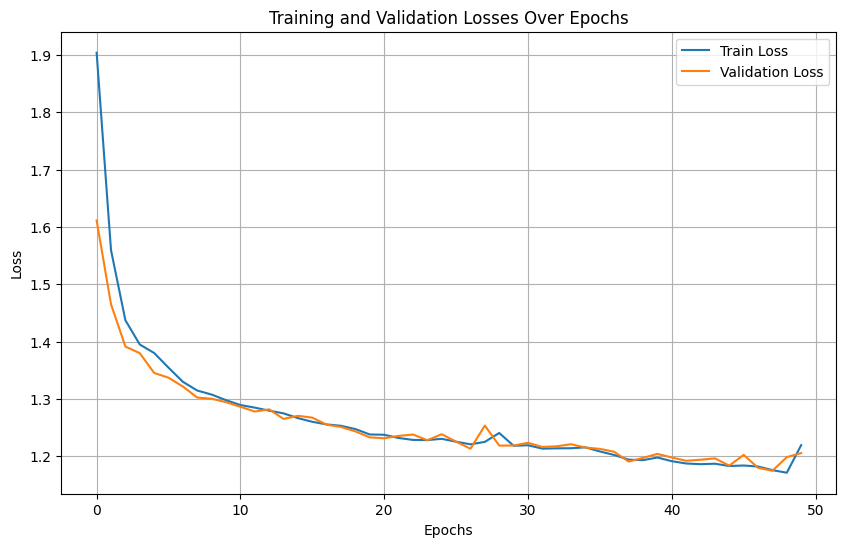

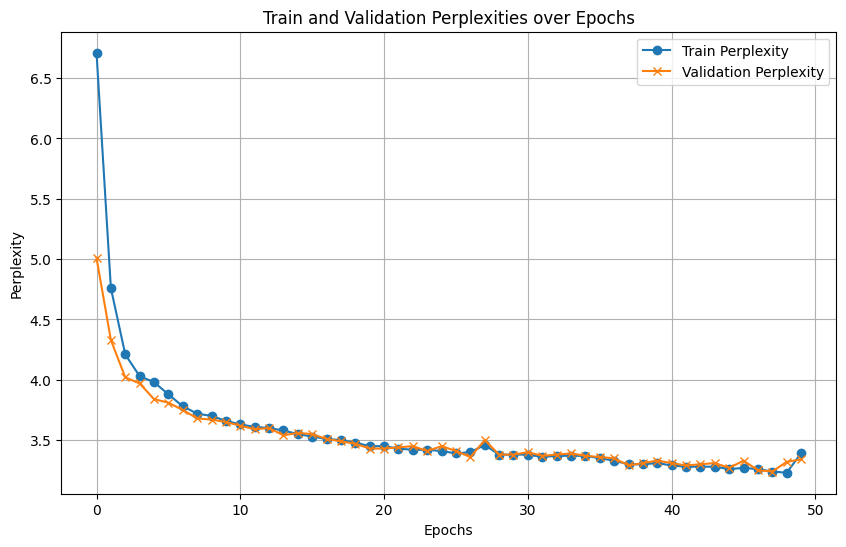

In [ ]:
# Small model with character level tokenizer

# Extract training and validation losses and perplexities
epochs = list(range(50))
train_losses = [
    1.9038, 1.5596, 1.4373, 1.3950, 1.3802, 1.3546, 1.3299, 1.3147, 1.3077, 1.2979,
    1.2894, 1.2849, 1.2796, 1.2749, 1.2666, 1.2602, 1.2556, 1.2532, 1.2475, 1.2381,
    1.2376, 1.2320, 1.2286, 1.2283, 1.2305, 1.2255, 1.2209, 1.2252, 1.2407, 1.2184,
    1.2193, 1.2134, 1.2139, 1.2141, 1.2157, 1.2085, 1.2023, 1.1942, 1.1933, 1.1979,
    1.1915, 1.1875, 1.1863, 1.1871, 1.1831, 1.1840, 1.1822, 1.1759, 1.1714, 1.2195
]
val_losses = [
    1.6113, 1.4652, 1.3914, 1.3799, 1.3454, 1.3371, 1.3217, 1.3025, 1.3004, 1.2944,
    1.2864, 1.2781, 1.2819, 1.2652, 1.2706, 1.2675, 1.2551, 1.2512, 1.2434, 1.2330,
    1.2315, 1.2356, 1.2380, 1.2281, 1.2385, 1.2256, 1.2132, 1.2536, 1.2187, 1.2188,
    1.2236, 1.2163, 1.2175, 1.2211, 1.2152, 1.2130, 1.2079, 1.1908, 1.1973, 1.2042,
    1.1980, 1.1922, 1.1941, 1.1964, 1.1838, 1.2025, 1.1800, 1.1748, 1.1986, 1.2057
]

train_ppl = [6.71, 4.76, 4.21, 4.03, 3.98, 3.88, 3.78, 3.72, 3.70, 3.66, 3.63, 3.61, 3.60, 3.58, 3.55, 3.53, 3.51, 3.50, 3.48, 3.45,
             3.45, 3.43, 3.42, 3.42, 3.41, 3.39, 3.40, 3.46, 3.38, 3.38, 3.38, 3.36, 3.37, 3.37, 3.37, 3.35, 3.33, 3.30, 3.30, 3.31,
             3.29, 3.28, 3.28, 3.28, 3.26, 3.27, 3.26, 3.24, 3.23, 3.39]
val_ppl = [5.01, 4.33, 4.02, 3.97, 3.84, 3.81, 3.75, 3.68, 3.67, 3.65, 3.62, 3.59, 3.60, 3.54, 3.56, 3.55, 3.51, 3.49, 3.47, 3.43,
           3.43, 3.44, 3.45, 3.41, 3.45, 3.41, 3.36, 3.50, 3.38, 3.38, 3.40, 3.37, 3.38, 3.39, 3.37, 3.36, 3.35, 3.29, 3.31, 3.33,
           3.31, 3.29, 3.30, 3.31, 3.27, 3.33, 3.25, 3.24, 3.32, 3.34]

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_ppl, label='Train Perplexity', marker='o')
plt.plot(epochs, val_ppl, label='Validation Perplexity', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Train and Validation Perplexities over Epochs')
plt.legend()
plt.grid(True)
plt.show()

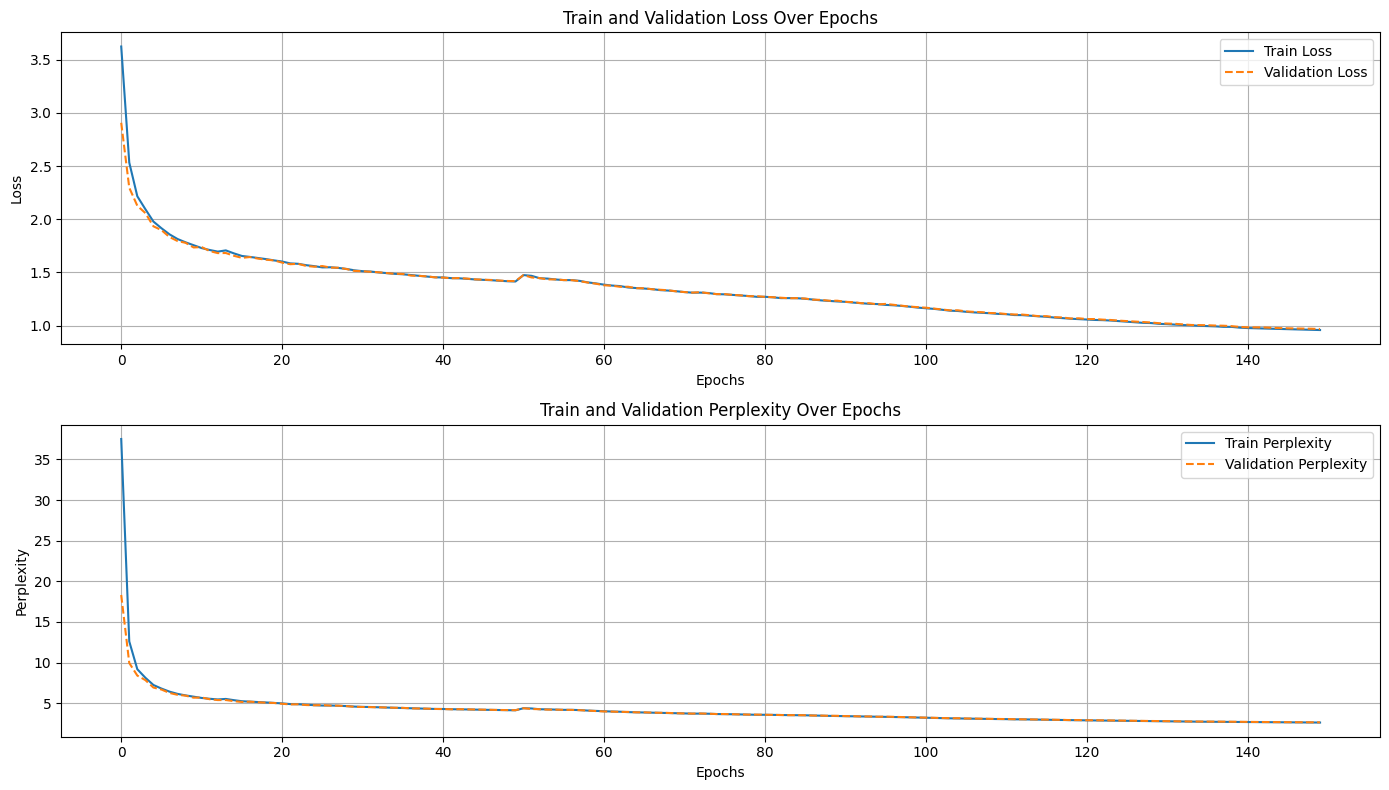

In [ ]:
# Large model with character level tokenizer


# Loss and perplexity values
epochs = list(range(150))
train_losses = [
    3.6249, 2.5332, 2.2164, 2.0950, 1.9786, 1.9156, 1.8583, 1.8143, 1.7832, 1.7566,
    1.7289, 1.7109, 1.6958, 1.7073, 1.6794, 1.6548, 1.6459, 1.6359, 1.6254, 1.6131,
    1.6025, 1.5851, 1.5811, 1.5681, 1.5590, 1.5473, 1.5485, 1.5423, 1.5328, 1.5197,
    1.5118, 1.5083, 1.5000, 1.4937, 1.4868, 1.4826, 1.4753, 1.4671, 1.4616, 1.4542,
    1.4527, 1.4464, 1.4447, 1.4400, 1.4338, 1.4305, 1.4267, 1.4215, 1.4172, 1.4147,
    1.4749, 1.4681, 1.4457, 1.4419, 1.4337, 1.4278, 1.4279, 1.4203, 1.4062, 1.3967,
    1.3851, 1.3766, 1.3715, 1.3585, 1.3530, 1.3486, 1.3427, 1.3335, 1.3293, 1.3230,
    1.3154, 1.3095, 1.3102, 1.3063, 1.2958, 1.2940, 1.2886, 1.2831, 1.2779, 1.2706,
    1.2708, 1.2659, 1.2582, 1.2585, 1.2573, 1.2523, 1.2443, 1.2369, 1.2319, 1.2271,
    1.2233, 1.2162, 1.2104, 1.2047, 1.2023, 1.1947, 1.1908, 1.1850, 1.1777, 1.1691,
    1.1634, 1.1572, 1.1493, 1.1403, 1.1372, 1.1297, 1.1241, 1.1199, 1.1161, 1.1100,
    1.1074, 1.0992, 1.0984, 1.0926, 1.0874, 1.0827, 1.0756, 1.0701, 1.0647, 1.0613,
    1.0569, 1.0531, 1.0512, 1.0474, 1.0420, 1.0371, 1.0309, 1.0258, 1.0238, 1.0163,
    1.0136, 1.0093, 1.0049, 1.0026, 0.9979, 0.9951, 0.9927, 0.9882, 0.9878, 0.9806,
    0.9769, 0.9745, 0.9730, 0.9705, 0.9686, 0.9662, 0.9650, 0.9630, 0.9608, 0.9581
]
val_losses = [
    2.9075, 2.2966, 2.1271, 2.0584, 1.9340, 1.8979, 1.8332, 1.7953, 1.7785, 1.7348,
    1.7384, 1.7009, 1.6818, 1.6826, 1.6567, 1.6370, 1.6448, 1.6300, 1.6198, 1.6131,
    1.5925, 1.5774, 1.5809, 1.5606, 1.5539, 1.5599, 1.5455, 1.5441, 1.5320, 1.5142,
    1.5115, 1.5058, 1.5013, 1.4936, 1.4874, 1.4858, 1.4704, 1.4676, 1.4629, 1.4538,
    1.4517, 1.4449, 1.4470, 1.4419, 1.4347, 1.4322, 1.4290, 1.4237, 1.4195, 1.4181,
    1.4753, 1.4526, 1.4466, 1.4344, 1.4346, 1.4280, 1.4268, 1.4176, 1.4045, 1.3939,
    1.3792, 1.3753, 1.3648, 1.3654, 1.3515, 1.3512, 1.3415, 1.3371, 1.3321, 1.3216,
    1.3152, 1.3102, 1.3145, 1.3036, 1.2960, 1.2960, 1.2884, 1.2841, 1.2765, 1.2767,
    1.2701, 1.2669, 1.2622, 1.2571, 1.2583, 1.2544, 1.2434, 1.2418, 1.2337, 1.2340,
    1.2233, 1.2204, 1.2104, 1.2103, 1.1988, 1.2038, 1.1954, 1.1868, 1.1786, 1.1736,
    1.1683, 1.1598, 1.1504, 1.1433, 1.1437, 1.1334, 1.1289, 1.1259, 1.1181, 1.1162,
    1.1086, 1.1046, 1.1035, 1.0970, 1.0885, 1.0885, 1.0791, 1.0763, 1.0665, 1.0688,
    1.0614, 1.0615, 1.0559, 1.0526, 1.0466, 1.0420, 1.0370, 1.0336, 1.0291, 1.0222,
    1.0197, 1.0164, 1.0106, 1.0058, 1.0050, 1.0032, 1.0002, 0.9987, 0.9946, 0.9877,
    0.9833, 0.9829, 0.9824, 0.9792, 0.9763, 0.9745, 0.9727, 0.9720, 0.9704, 0.9675
]

# Perplexities
train_perplexities = [math.exp(loss) for loss in train_losses]
val_perplexities = [math.exp(loss) for loss in val_losses]

# Plotting
plt.figure(figsize=(14, 8))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
plt.title('Train and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Perplexity plot
plt.subplot(2, 1, 2)
plt.plot(epochs, train_perplexities, label='Train Perplexity')
plt.plot(epochs, val_perplexities, label='Validation Perplexity', linestyle='--')
plt.title('Train and Validation Perplexity Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

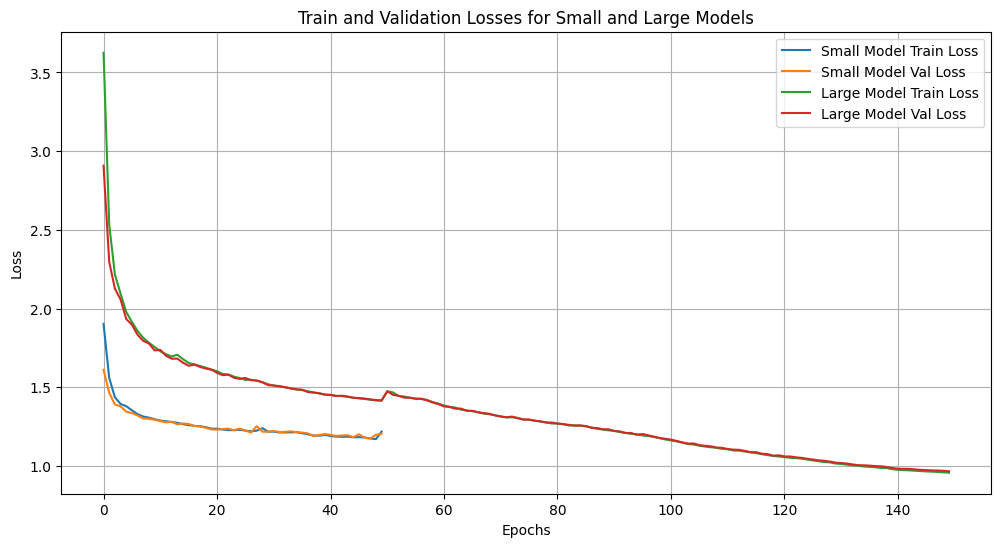

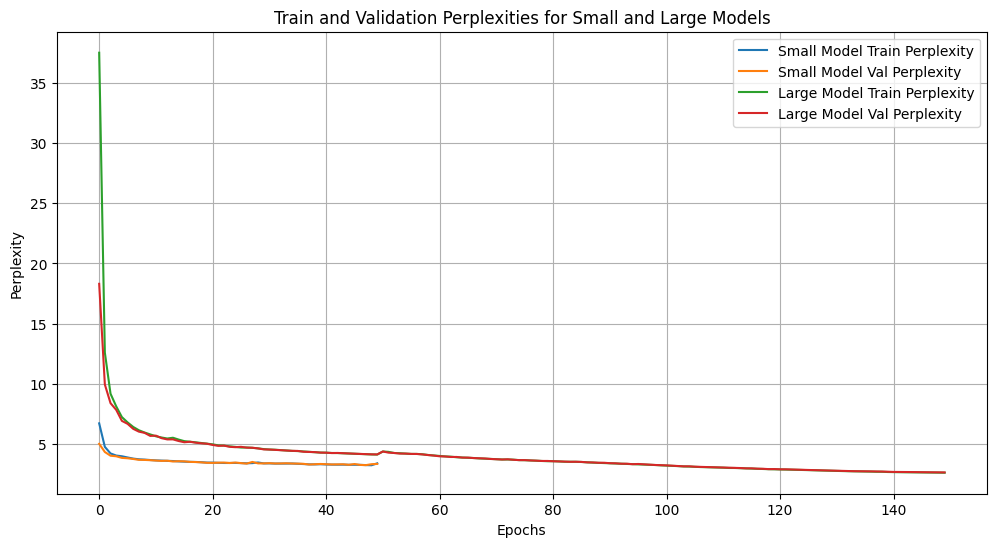

In [ ]:
# Data for the small model
small_model_train_losses = [
    1.9038, 1.5596, 1.4373, 1.3950, 1.3802, 1.3546, 1.3299, 1.3147, 1.3077, 1.2979,
    1.2894, 1.2849, 1.2796, 1.2749, 1.2666, 1.2602, 1.2556, 1.2532, 1.2475, 1.2381,
    1.2376, 1.2320, 1.2286, 1.2283, 1.2305, 1.2255, 1.2209, 1.2252, 1.2407, 1.2184,
    1.2193, 1.2134, 1.2139, 1.2141, 1.2157, 1.2085, 1.2023, 1.1942, 1.1933, 1.1979,
    1.1915, 1.1875, 1.1863, 1.1871, 1.1831, 1.1840, 1.1822, 1.1759, 1.1714, 1.2195
]
small_model_val_losses = [
    1.6113, 1.4652, 1.3914, 1.3799, 1.3454, 1.3371, 1.3217, 1.3025, 1.3004, 1.2944,
    1.2864, 1.2781, 1.2819, 1.2652, 1.2706, 1.2675, 1.2551, 1.2512, 1.2434, 1.2330,
    1.2315, 1.2356, 1.2380, 1.2281, 1.2385, 1.2256, 1.2132, 1.2536, 1.2187, 1.2188,
    1.2236, 1.2163, 1.2175, 1.2211, 1.2152, 1.2130, 1.2079, 1.1908, 1.1973, 1.2042,
    1.1980, 1.1922, 1.1941, 1.1964, 1.1838, 1.2025, 1.1800, 1.1748, 1.1986, 1.2057
]

small_model_train_perplexities = [math.exp(loss) for loss in small_model_train_losses]
small_model_val_perplexities = [math.exp(loss) for loss in small_model_val_losses]

# Data for the large model
large_model_train_losses = [
    3.6249, 2.5332, 2.2164, 2.0950, 1.9786, 1.9156, 1.8583, 1.8143, 1.7832, 1.7566,
    1.7289, 1.7109, 1.6958, 1.7073, 1.6794, 1.6548, 1.6459, 1.6359, 1.6254, 1.6131,
    1.6025, 1.5851, 1.5811, 1.5681, 1.5590, 1.5473, 1.5485, 1.5423, 1.5328, 1.5197,
    1.5118, 1.5083, 1.5000, 1.4937, 1.4868, 1.4826, 1.4753, 1.4671, 1.4616, 1.4542,
    1.4527, 1.4464, 1.4447, 1.4400, 1.4338, 1.4305, 1.4267, 1.4215, 1.4172, 1.4147,
    1.4749, 1.4681, 1.4457, 1.4419, 1.4337, 1.4278, 1.4279, 1.4203, 1.4062, 1.3967,
    1.3851, 1.3766, 1.3715, 1.3585, 1.3530, 1.3486, 1.3427, 1.3335, 1.3293, 1.3230,
    1.3154, 1.3095, 1.3102, 1.3063, 1.2958, 1.2940, 1.2886, 1.2831, 1.2779, 1.2706,
    1.2708, 1.2659, 1.2582, 1.2585, 1.2573, 1.2523, 1.2443, 1.2369, 1.2319, 1.2271,
    1.2233, 1.2162, 1.2104, 1.2047, 1.2023, 1.1947, 1.1908, 1.1850, 1.1777, 1.1691,
    1.1634, 1.1572, 1.1493, 1.1403, 1.1372, 1.1297, 1.1241, 1.1199, 1.1161, 1.1100,
    1.1074, 1.0992, 1.0984, 1.0926, 1.0874, 1.0827, 1.0756, 1.0701, 1.0647, 1.0613,
    1.0569, 1.0531, 1.0512, 1.0474, 1.0420, 1.0371, 1.0309, 1.0258, 1.0238, 1.0163,
    1.0136, 1.0093, 1.0049, 1.0026, 0.9979, 0.9951, 0.9927, 0.9882, 0.9878, 0.9806,
    0.9769, 0.9745, 0.9730, 0.9705, 0.9686, 0.9662, 0.9650, 0.9630, 0.9608, 0.9581
]
large_model_val_losses = [
    2.9075, 2.2966, 2.1271, 2.0584, 1.9340, 1.8979, 1.8332, 1.7953, 1.7785, 1.7348,
    1.7384, 1.7009, 1.6818, 1.6826, 1.6567, 1.6370, 1.6448, 1.6300, 1.6198, 1.6131,
    1.5925, 1.5774, 1.5809, 1.5606, 1.5539, 1.5599, 1.5455, 1.5441, 1.5320, 1.5142,
    1.5115, 1.5058, 1.5013, 1.4936, 1.4874, 1.4858, 1.4704, 1.4676, 1.4629, 1.4538,
    1.4517, 1.4449, 1.4470, 1.4419, 1.4347, 1.4322, 1.4290, 1.4237, 1.4195, 1.4181,
    1.4753, 1.4526, 1.4466, 1.4344, 1.4346, 1.4280, 1.4268, 1.4176, 1.4045, 1.3939,
    1.3792, 1.3753, 1.3648, 1.3654, 1.3515, 1.3512, 1.3415, 1.3371, 1.3321, 1.3216,
    1.3152, 1.3102, 1.3145, 1.3036, 1.2960, 1.2960, 1.2884, 1.2841, 1.2765, 1.2767,
    1.2701, 1.2669, 1.2622, 1.2571, 1.2583, 1.2544, 1.2434, 1.2418, 1.2337, 1.2340,
    1.2233, 1.2204, 1.2104, 1.2103, 1.1988, 1.2038, 1.1954, 1.1868, 1.1786, 1.1736,
    1.1683, 1.1598, 1.1504, 1.1433, 1.1437, 1.1334, 1.1289, 1.1259, 1.1181, 1.1162,
    1.1086, 1.1046, 1.1035, 1.0970, 1.0885, 1.0885, 1.0791, 1.0763, 1.0665, 1.0688,
    1.0614, 1.0615, 1.0559, 1.0526, 1.0466, 1.0420, 1.0370, 1.0336, 1.0291, 1.0222,
    1.0197, 1.0164, 1.0106, 1.0058, 1.0050, 1.0032, 1.0002, 0.9987, 0.9946, 0.9877,
    0.9833, 0.9829, 0.9824, 0.9792, 0.9763, 0.9745, 0.9727, 0.9720, 0.9704, 0.9675
]

large_model_train_perplexities = [math.exp(loss) for loss in large_model_train_losses]
large_model_val_perplexities = [math.exp(loss) for loss in large_model_val_losses]

# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(small_model_train_losses, label="Small Model Train Loss")
plt.plot(small_model_val_losses, label="Small Model Val Loss")
plt.plot(large_model_train_losses, label="Large Model Train Loss")
plt.plot(large_model_val_losses, label="Large Model Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses for Small and Large Models")
plt.legend()
plt.grid(True)
plt.show()

# Plot perplexities
plt.figure(figsize=(12, 6))
plt.plot(small_model_train_perplexities, label="Small Model Train Perplexity")
plt.plot(small_model_val_perplexities, label="Small Model Val Perplexity")
plt.plot(large_model_train_perplexities, label="Large Model Train Perplexity")
plt.plot(large_model_val_perplexities, label="Large Model Val Perplexity")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Train and Validation Perplexities for Small and Large Models")
plt.legend()
plt.grid(True)
plt.show()

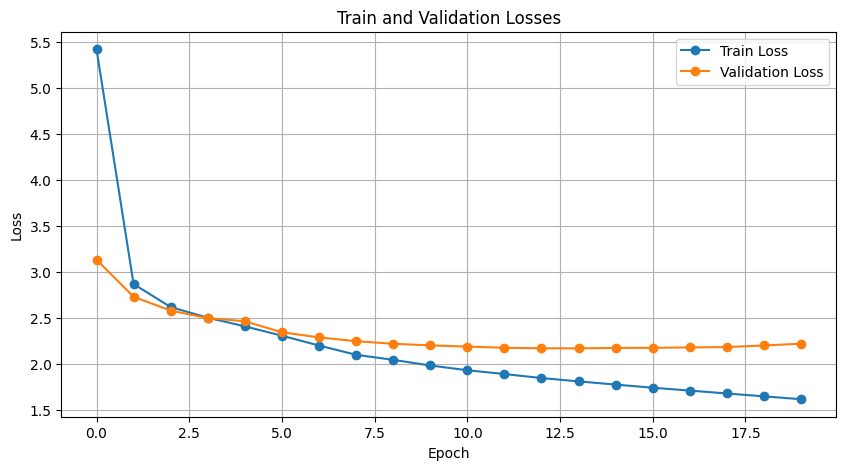

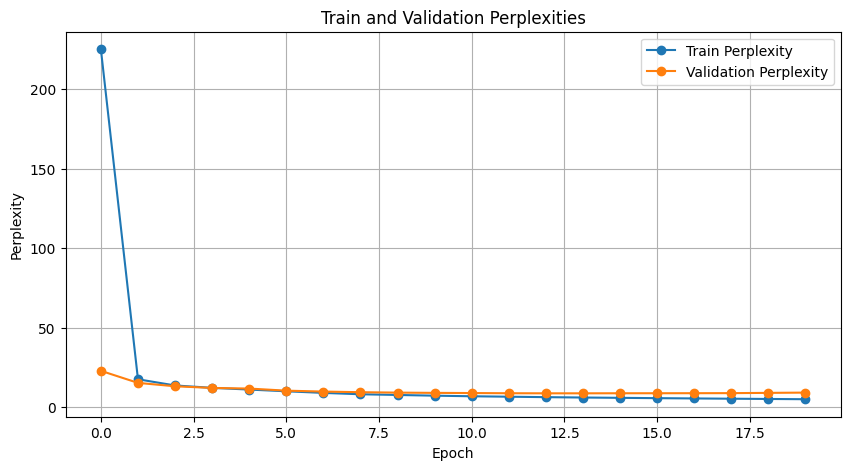

In [ ]:
# Small model with subword level tokenizer

# Data from the epochs
epochs = list(range(20))
train_losses = [5.4163, 2.8660, 2.6161, 2.5002, 2.4069, 2.3050, 2.1984, 2.0977, 2.0430, 1.9817,
                1.9297, 1.8889, 1.8453, 1.8089, 1.7742, 1.7400, 1.7089, 1.6776, 1.6463, 1.6152]
val_losses = [3.1305, 2.7277, 2.5778, 2.4958, 2.4619, 2.3423, 2.2865, 2.2454, 2.2174, 2.2000,
              2.1869, 2.1741, 2.1684, 2.1676, 2.1721, 2.1735, 2.1774, 2.1818, 2.1991, 2.2179]
train_perplexities = [225.05, 17.57, 13.68, 12.18, 11.10, 10.02, 9.01, 8.15, 7.71, 7.26,
                      6.89, 6.61, 6.33, 6.10, 5.90, 5.70, 5.52, 5.35, 5.19, 5.03]
val_perplexities = [22.88, 15.30, 13.17, 12.13, 11.73, 10.41, 9.84, 9.44, 9.18, 9.02,
                    8.91, 8.79, 8.74, 8.74, 8.78, 8.79, 8.82, 8.86, 9.02, 9.19]

# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Train and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting perplexities
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_perplexities, label='Train Perplexity', marker='o')
plt.plot(epochs, val_perplexities, label='Validation Perplexity', marker='o')
plt.title('Train and Validation Perplexities')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid()
plt.show()

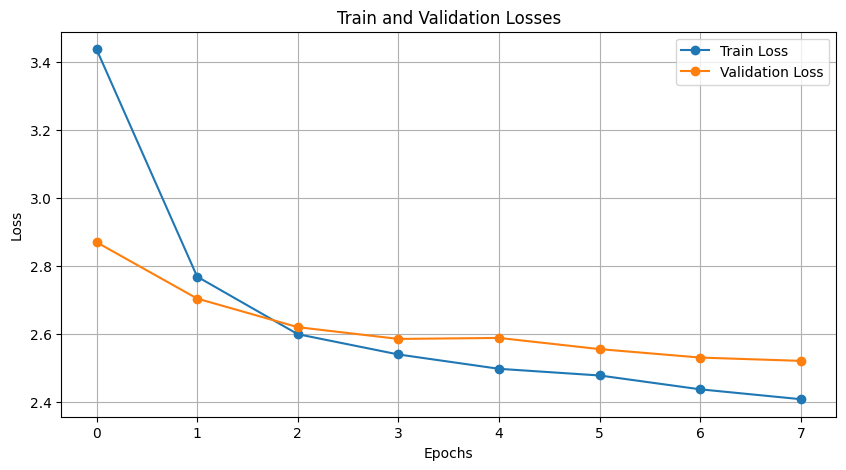

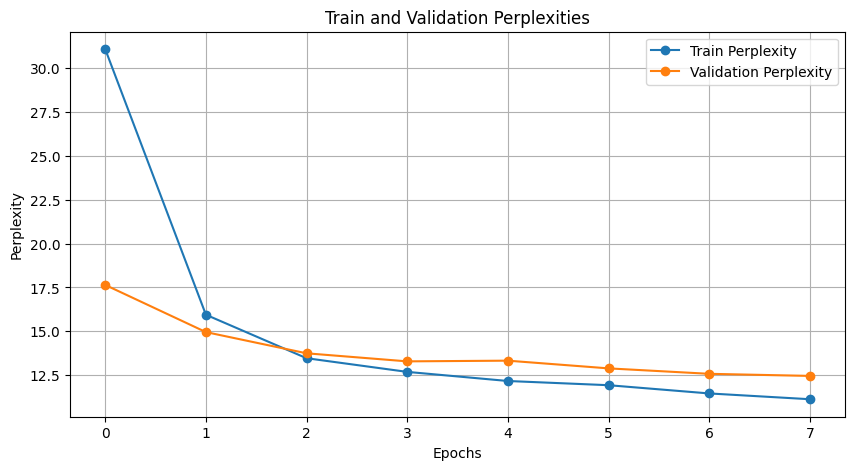

In [ ]:
# Medium model with subword level tokenizer
epochs = list(range(8))
train_losses = [3.4368, 2.7689, 2.5999, 2.5403, 2.4982, 2.4786, 2.4379, 2.4089]
val_losses = [2.8701, 2.7045, 2.6205, 2.5860, 2.5889, 2.5560, 2.5312, 2.5215]

train_perplexities = [31.09, 15.94, 13.46, 12.68, 12.16, 11.92, 11.45, 11.12]
val_perplexities = [17.64, 14.95, 13.74, 13.28, 13.32, 12.88, 12.57, 12.45]

# Plot Train/Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Plot Train/Validation Perplexities
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_perplexities, label='Train Perplexity', marker='o')
plt.plot(epochs, val_perplexities, label='Validation Perplexity', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Train and Validation Perplexities')
plt.legend()
plt.grid(True)
plt.show()

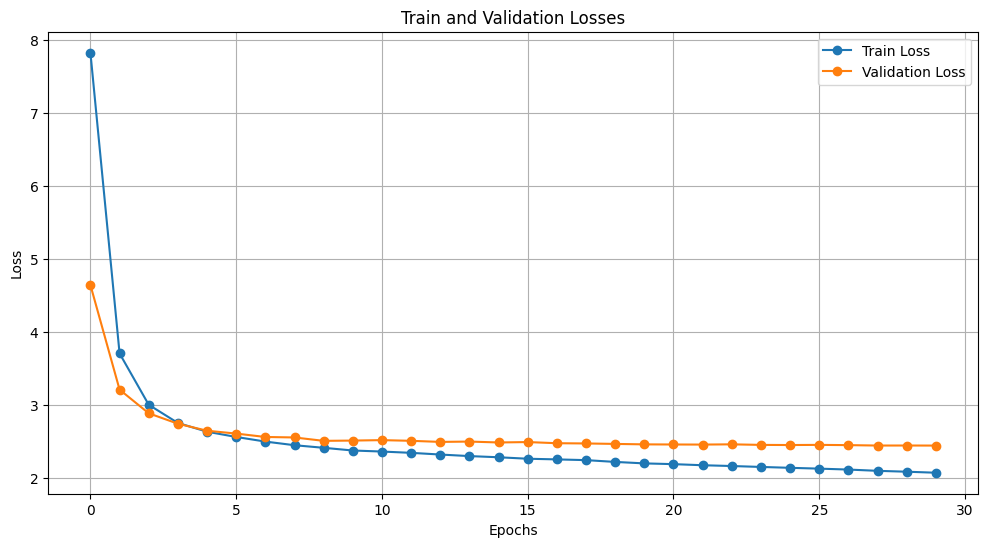

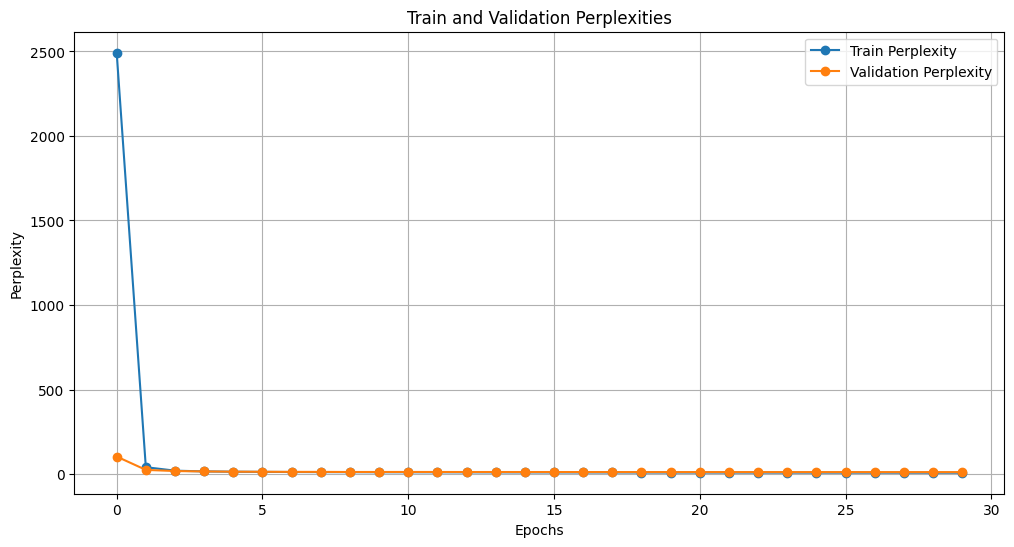

In [ ]:
# Large model with subword level tokenizer

# Epochs and corresponding train/val losses and perplexities
epochs = list(range(30))
train_losses = [
    7.8210, 3.7036, 3.0007, 2.7516, 2.6319, 2.5599, 2.4967, 2.4469, 2.4115, 2.3745,
    2.3602, 2.3425, 2.3193, 2.2980, 2.2820, 2.2618, 2.2527, 2.2427, 2.2183, 2.1980,
    2.1877, 2.1728, 2.1620, 2.1495, 2.1375, 2.1262, 2.1136, 2.0962, 2.0841, 2.0703
]

val_losses = [
    4.6401, 3.2079, 2.8840, 2.7413, 2.6452, 2.6062, 2.5597, 2.5531, 2.5067, 2.5105,
    2.5166, 2.5072, 2.4922, 2.4968, 2.4845, 2.4901, 2.4743, 2.4710, 2.4647, 2.4585,
    2.4568, 2.4557, 2.4590, 2.4513, 2.4494, 2.4515, 2.4481, 2.4424, 2.4429, 2.4420
]

# Convert losses to perplexities
train_perplexities = [math.exp(loss) for loss in train_losses]
val_perplexities = [math.exp(loss) for loss in val_losses]

# Plot train/val losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

# Plot train/val perplexities
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_perplexities, label="Train Perplexity", marker="o")
plt.plot(epochs, val_perplexities, label="Validation Perplexity", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Train and Validation Perplexities")
plt.legend()
plt.grid(True)
plt.show()

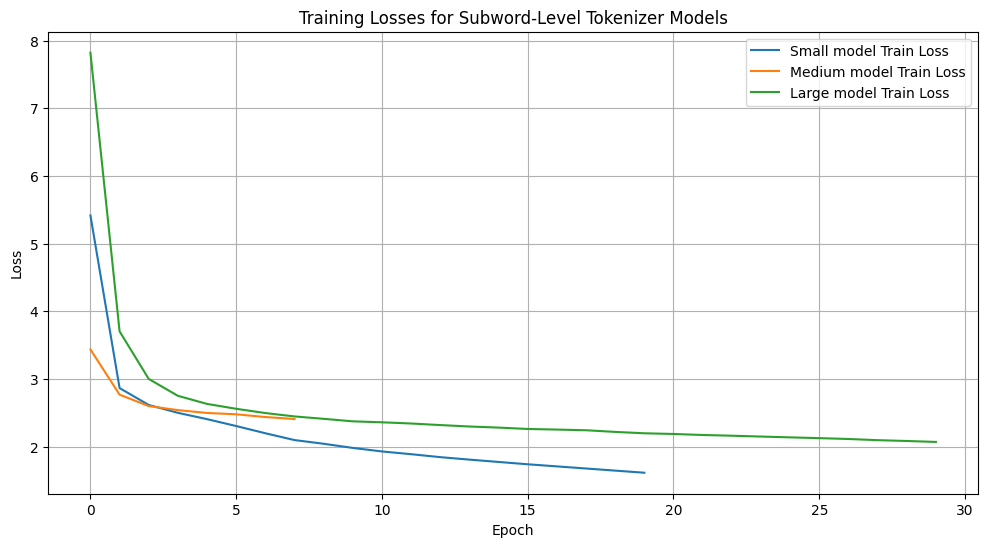

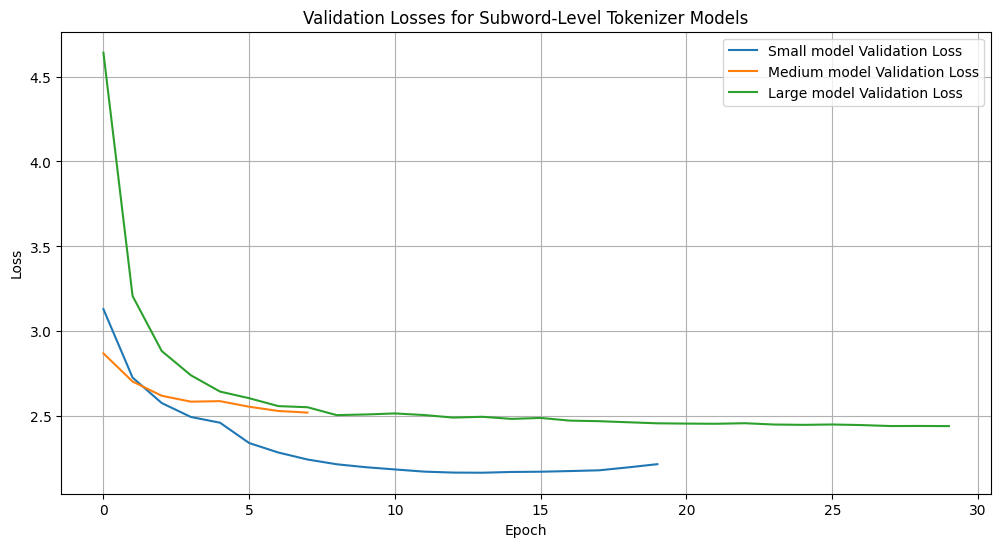

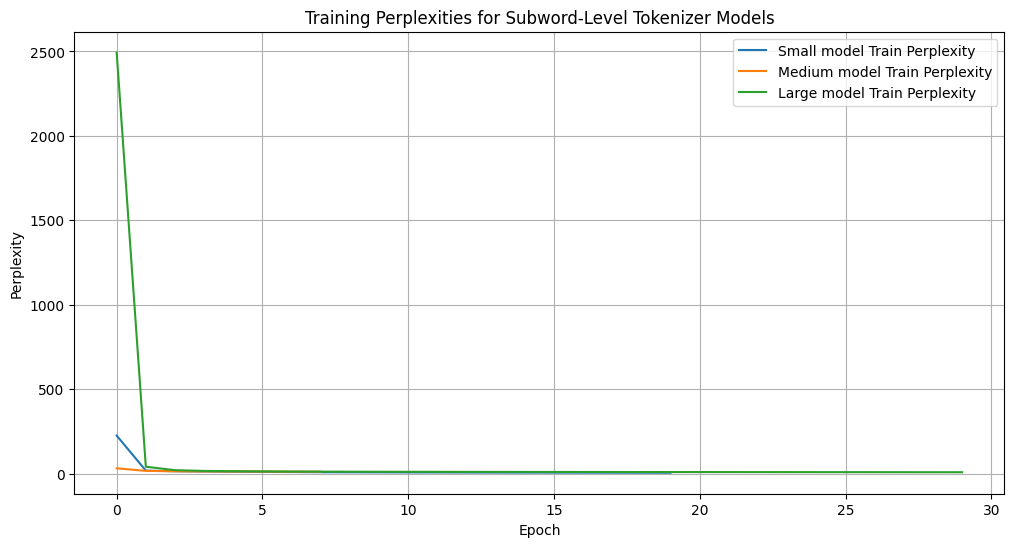

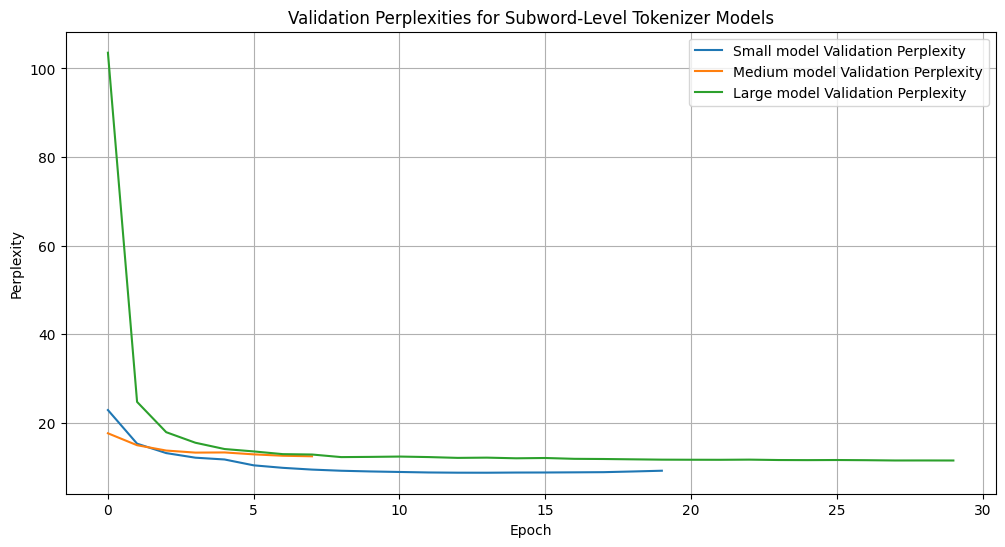

In [3]:
# Include the full 30 epochs of the large model in the dataset for plotting
datasets = [
    {
        "label": "Small model",
        "train_losses": [5.4163, 2.8660, 2.6161, 2.5002, 2.4069, 2.3050, 2.1984, 2.0977, 2.0430, 1.9817,
                         1.9297, 1.8889, 1.8453, 1.8089, 1.7742, 1.7400, 1.7089, 1.6776, 1.6463, 1.6152],
        "val_losses": [3.1305, 2.7277, 2.5778, 2.4958, 2.4619, 2.3423, 2.2865, 2.2454, 2.2174, 2.2000,
                       2.1869, 2.1741, 2.1684, 2.1676, 2.1721, 2.1735, 2.1774, 2.1818, 2.1991, 2.2179]
    },
    {
        "label": "Medium model",
        "train_losses": [3.4368, 2.7689, 2.5999, 2.5403, 2.4982, 2.4786, 2.4379, 2.4089],
        "val_losses": [2.8701, 2.7045, 2.6205, 2.5860, 2.5889, 2.5560, 2.5312, 2.5215]
    },
    {
        "label": "Large model",
        "train_losses": [
            7.8210, 3.7036, 3.0007, 2.7516, 2.6319, 2.5599, 2.4967, 2.4469, 2.4115, 2.3745,
            2.3602, 2.3425, 2.3193, 2.2980, 2.2820, 2.2618, 2.2527, 2.2427, 2.2183, 2.1980,
            2.1877, 2.1728, 2.1620, 2.1495, 2.1375, 2.1262, 2.1136, 2.0962, 2.0841, 2.0703
        ],
        "val_losses": [
            4.6401, 3.2079, 2.8840, 2.7413, 2.6452, 2.6062, 2.5597, 2.5531, 2.5067, 2.5105,
            2.5166, 2.5072, 2.4922, 2.4968, 2.4845, 2.4901, 2.4743, 2.4710, 2.4647, 2.4585,
            2.4568, 2.4557, 2.4590, 2.4513, 2.4494, 2.4515, 2.4481, 2.4424, 2.4429, 2.4420
        ]
    }
]

# Plot Training Losses
plt.figure(figsize=(12, 6))
for data in datasets:
    plt.plot(data["train_losses"], label=f"{data['label']} Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses for Subword-Level Tokenizer Models")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Losses
plt.figure(figsize=(12, 6))
for data in datasets:
    plt.plot(data["val_losses"], label=f"{data['label']} Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Losses for Subword-Level Tokenizer Models")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Perplexities
plt.figure(figsize=(12, 6))
for data in datasets:
    train_perplexities = [math.exp(loss) for loss in data["train_losses"]]
    plt.plot(train_perplexities, label=f"{data['label']} Train Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Training Perplexities for Subword-Level Tokenizer Models")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Perplexities
plt.figure(figsize=(12, 6))
for data in datasets:
    val_perplexities = [math.exp(loss) for loss in data["val_losses"]]
    plt.plot(val_perplexities, label=f"{data['label']} Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Validation Perplexities for Subword-Level Tokenizer Models")
plt.legend()
plt.grid(True)
plt.show()

# Qualitative samples

In [ ]:
subsample_size = 10  # Choose a smaller number of lines
sampled_lines = random.sample(test_lines, subsample_size)

input_texts = []
reference_texts = []

num_input_tokens = 5  # Number of tokens from the content to include as input

for line in sampled_lines:  # Use validation set for evaluation
    tokens = line.split()

    # Separate metadata and content
    metadata_tokens = [t for t in tokens if "<PLAY=" in t or "<SPEAKER=" in t]
    content_tokens = [t for t in tokens if "<PLAY=" not in t and "<SPEAKER=" not in t]

    # Ensure there is enough content after the metadata
    if len(content_tokens) > num_input_tokens:
        input_texts.append(" ".join(metadata_tokens + content_tokens[:num_input_tokens]))
        reference_texts.append(" ".join(content_tokens[num_input_tokens:]))

print(len(input_texts))
print(len(reference_texts))

10
10


In [ ]:
print(*input_texts, sep="\n")

<PLAY=Loves <SPEAKER=FERDINAND> Labours Lost> Soft! whither away
<PLAY=As <SPEAKER=OLIVER> you like it> an end
<PLAY=Henry <SPEAKER=MARGARET VI Part 2> JOURDAIN> By
<PLAY=Twelfth <SPEAKER=SIR Night> TOBY BELCH> Pourquoi, my
<PLAY=Henry <SPEAKER=CADE> VI Part 2> Enter a
<PLAY=The <SPEAKER=PROSPERO> Tempest> Now my charms are
<PLAY=A <SPEAKER=AUTOLYCUS> Winters Tale> should buy first,
<PLAY=Henry <SPEAKER=DAUPHIN> V> not warily, fall into
<PLAY=Coriolanus> <SPEAKER=SICINIUS> More than his singularity, he
<PLAY=Richard <SPEAKER=HENRY II> BOLINGBROKE> And, as my


In [ ]:
print(*reference_texts, sep="\n")

so fast?
of him, for my soul, yet I know not why,
the eternal God, whose name and power
dear knight?
Messenger
all o'erthrown,
as if my trinkets had been
foul bogs. I had rather have
goes
fortune ripens with thy love,


In [ ]:
generated_texts_small_char_model = [generate_char_text(
    small_char_model,
    char_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]

generated_texts_large_char_model = [generate_char_text(
    large_char_model,
    char_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]

generated_texts_small_subword_model = [generate_subword_text(
    small_subword_model,
    subword_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]

generated_texts_medium_subword_model = [generate_subword_text(
    medium_subword_model,
    subword_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]


generated_texts_large_subword_model = [generate_subword_text(
    large_subword_model,
    subword_tokenizer,
    start_text=text,
    top_k=10,
    temperature=0.7
) for text in input_texts]


In [ ]:
for i in range(10):
  print("-------------------------------------------------------------")
  print("Input text: ", input_texts[i])
  print("Reference text: ", reference_texts[i])
  print("Full line: ", input_texts[i] + " " + reference_texts[i])
  print("Generated text (small char model): ", generated_texts_small_char_model[i])
  print("Generated text (large char model): ", generated_texts_large_char_model[i])
  print("Generated text (small subword model): ", generated_texts_small_subword_model[i])
  print("Generated text (medium subword model): ", generated_texts_medium_subword_model[i])
  print("Generated text (large subword model): ", generated_texts_large_subword_model[i])

-------------------------------------------------------------
Input text:  <PLAY=Loves <SPEAKER=FERDINAND> Labours Lost> Soft! whither away
Reference text:  so fast?
Full line:  <PLAY=Loves <SPEAKER=FERDINAND> Labours Lost> Soft! whither away so fast?
Generated text (small char model):  <PLAY=Loves <SPEAKER=FERDINAND> Labours Lost> Soft! whither away, ind fa hof t,
Generated text (large char model):  <PLAY=Loves <SPEAKER=FERDINAND> Labours Lost> Soft! whither away hand, spectan thou
Generated text (small subword model):  <PLAY=Loves <SPEAKER=FERDINAND> Labours Lost> Soft! whither away, and,
Generated text (medium subword model):  <PLAY=Loves <SPEAKER=FERDINAND> Labours Lost> Soft! whither away, my
Generated text (large subword model):  <PLAY=Loves <SPEAKER=FERDINAND> Labours Lost> Soft! whither away,
-------------------------------------------------------------
Input text:  <PLAY=As <SPEAKER=OLIVER> you like it> an end
Reference text:  of him, for my soul, yet I know not why,
Full line